In [5]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from dataclasses import dataclass
from typing import Literal, Optional, Dict, Tuple, List, Any, Sequence
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import PchipInterpolator, interp1d
from sklearn.decomposition import TruncatedSVD, PCA

from diffmap.lifting import (
    build_training_pairs,
    build_time_augmented_training_pairs,
    compute_lift_metrics,
    lift_with_convex_hull,
    print_metric_table,
)
from mmsfm.data_utils import (
    find_holdout_index,
    get_marginals,
    invert_pca,
    pca_decode,
    split_train_holdout_marginals,
    to_images,
)
from mmsfm.viz import format_for_paper, plot_error_statistics, plot_field_comparisons

from diffmap.diffusion_maps import (
    select_epsilons_by_semigroup,
    time_coupled_diffusion_map,
    build_time_coupled_trajectory,
    fit_coordinate_splines,
    evaluate_coordinate_splines,
    fit_time_coupled_geometric_harmonics,
    time_coupled_geometric_harmonics_lift,
    ConvexHullInterpolator,
    TimeCoupledGeometricHarmonicsModel,
    TimeCoupledTrajectoryResult,
    interpolate_diffusion_embedding,
    build_markov_operators,
    fused_symmetric_step_operator,
    fractional_step_operator,
    normalize_markov_operator,
    _orient_svd,
)
import pandas as pd

from stiefel.stiefel import batch_stiefel_log, Stiefel_Log, Stiefel_Exp
from stiefel.barycenter import R_barycenter
from stiefel.projection_retraction import (
    st_retr_orthographic,
    st_inv_retr_orthographic,
)
from stiefel.error_measures import err_st

format_for_paper()



In [6]:
@dataclass
class LiftingConfig:
    holdout_time: float = 0.75
    gh_delta: float = 1e-3
    gh_ridge: float = 1e-6
    use_time_coupled_gh: bool = True
    convex_k: int = 64
    convex_max_iter: int = 200
    preimage_time_window: Optional[float] = None  # restrict neighbours to a local time window
    plot_samples: tuple[int, ...] = (0, 1, 2)
    vmax_mode: Literal["global", "per_sample"] = "global"
    time_match_tol: float = 1e-8


@dataclass
class LatentInterpolationResult:
    t_dense: np.ndarray                 # (n_dense,)
    phi_global_dense: np.ndarray        # (n_dense, n_samples, latent_dim)
    phi_frechet_dense: np.ndarray       # (n_dense, n_samples, latent_dim)
    phi_linear_dense: Optional[np.ndarray] = None # (n_dense, n_samples, latent_dim)
    phi_naive_dense: Optional[np.ndarray] = None # (n_dense, n_samples, latent_dim)
    
    # Store interpolators for exact evaluation if needed
    pchip_delta_global: Optional[PchipInterpolator] = None
    pchip_delta_fm: Optional[object] = None  # global pchip or list of windowed interpolators
    pchip_sigma: Optional[PchipInterpolator] = None
    pchip_pi: Optional[PchipInterpolator] = None
    
    # Base points
    U_global: Optional[np.ndarray] = None
    U_frechet: Optional[np.ndarray] = None
    frechet_mode: Literal['global', 'triplet'] = 'global'
    frechet_windows: Optional[List[Dict[str, Any]]] = None


@dataclass
class LiftingModels:
    convex: ConvexHullInterpolator
    tc_gh_model: Optional[TimeCoupledGeometricHarmonicsModel] = None


@dataclass
class PseudoDataConfig:
    n_dense: int = 200
    n_pseudo_per_interval: int = 3
    eta_fuse: float = 0.95
    alpha_grid: Optional[Sequence[float]] = None   # overrides n_pseudo_per_interval when provided
    interp_method: Literal['frechet', 'global', 'naive'] = 'frechet'
    frechet_mode: Literal['global', 'triplet'] = 'triplet'
    n_samples_vis: int = 8        # for trajectory plots
    n_samples_fields: int = 3     # for field strips



In [10]:
def load_tran_inclusions_data(data_path: Path = Path("../data/tran_inclusions.npz")):
    npz = np.load(data_path)
    resolution = int(np.sqrt(int(npz["data_dim"])))

    # Debug: print all available keys
    print("Available keys in npz:", list(npz.files))

    # Extract available times from marginals (not raw_marginal_)
    time_keys = [k for k in npz.files if k.startswith("marginal_")]
    times = sorted(float(k.replace("marginal_", "")) for k in time_keys)
    print("Times:", times)

    # Acquire marginals (raw preferred; PCA otherwise)
    times, marginals, mode = get_marginals(npz, choice="pca")
    _, raw_marginals, _ = get_marginals(npz, choice="raw")
    held_out_indices = npz.get("held_out_indices")
    if held_out_indices is not None:
        held_out_indices = np.asarray(held_out_indices, dtype=int)
    else:
        held_out_indices = np.array([], dtype=int)

    train_times, train_marginals, held_out_times, held_out_marginals, used_held_out_indices = split_train_holdout_marginals(
        times,
        marginals,
        held_out_indices,
    )
    times, marginals = train_times, train_marginals
    print("Using mode:", mode, "Found times:", times)
    if held_out_times:
        print(
            f"Held-out times at indices {used_held_out_indices}: {held_out_times} (excluded from training)"
        )

    # Load PCA metadata (used only when mode == 'pca')
    components = npz.get("pca_components")
    mean_vec = npz.get("pca_mean")
    explained_variance = npz.get("pca_explained_variance")
    is_whitened = bool(npz.get("is_whitened", False))
    whitening_epsilon = float(npz.get("whitening_epsilon", 0.0))
    
    # Assemble PCA snapshots into a tensor (time, samples, components)
    times_arr = np.array(times, dtype=np.float64)
    all_frames = np.stack([marginals[t] for t in times_arr])
    # exclude first time since it is for visualization only (as per original script)
    all_frames = all_frames[1:]
    times_arr = times_arr[1:]
    
    return times_arr, held_out_indices, held_out_times, all_frames, components, mean_vec, explained_variance, is_whitened, whitening_epsilon, resolution, raw_marginals, held_out_marginals

def compute_bandwidth_statistics(frames: np.ndarray) -> dict[str, np.ndarray]:
    medians, q1, q3, maxima = [], [], [], []
    for snapshot in frames:
        d2 = squareform(pdist(snapshot, metric='sqeuclidean'))
        mask = d2 > 0
        if np.any(mask):
            vals = d2[mask]
        else:
            vals = np.array([1.0])
        medians.append(float(np.median(vals)))
        q1.append(float(np.percentile(vals, 25)))
        q3.append(float(np.percentile(vals, 75)))
        maxima.append(float(np.max(vals)))
    return {
        'median': np.array(medians),
        'q1': np.array(q1),
        'q3': np.array(q3),
        'max': np.array(maxima),
    }


def align_frames_procrustes(U_stack: np.ndarray, U_ref: np.ndarray) -> np.ndarray:
    """Align each frame in U_stack to U_ref via orthogonal Procrustes."""
    aligned = []
    for i in range(U_stack.shape[0]):
        Ui = U_stack[i]
        M = Ui.T @ U_ref
        U, _, Vt = np.linalg.svd(M)
        R = U @ Vt
        aligned.append(Ui @ R)
    return np.stack(aligned, axis=0)


def choose_elbow_epsilons(semigroup_df, n_times: int) -> np.ndarray:
    """Pick per-time epsilons via an elbow (knee) heuristic on log-log SGE curves."""
    eps_out = np.zeros(n_times, dtype=np.float64)
    for idx in range(n_times):
        subset = semigroup_df[semigroup_df["time_index"] == idx].sort_values("epsilon")
        eps = subset["epsilon"].to_numpy()
        err = subset["semigroup_error"].to_numpy()
        if eps.size == 0:
            eps_out[idx] = np.nan
            continue
        if eps.size <= 2:
            eps_out[idx] = float(eps[err.argmin()])
            continue
        x = np.log(eps)
        y = np.log(err + 1e-30)
        start = np.array([x[0], y[0]])
        end = np.array([x[-1], y[-1]])
        line_vec = end - start
        norm = np.linalg.norm(line_vec)
        if norm < 1e-12:
            eps_out[idx] = float(eps[err.argmin()])
            continue
        line_unit = line_vec / norm
        distances = []
        for xi, yi in zip(x, y):
            pt = np.array([xi, yi])
            proj_len = np.dot(pt - start, line_unit)
            proj = start + proj_len * line_unit
            distances.append(np.linalg.norm(pt - proj))
        knee_idx = int(np.argmax(distances))
        eps_out[idx] = float(eps[knee_idx])
    return eps_out

def build_time_coupled_embeddings(
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    tc_k: int = 8,
    alpha: float = 0.5,
    beta: float = -0.2,
    use_variable_bandwidth: bool = False,
    *,
    base_epsilons: Optional[np.ndarray] = None,
    scales: Optional[np.ndarray] = None,
    sample_size: Optional[int] = None,
    rng_seed: int = 0,
    semigroup_norm: str = 'operator',
    epsilon_selection: Literal['elbow', 'min', 'first_local_minimum'] = 'elbow',
):
    if base_epsilons is None:
        bandwidth_stats = compute_bandwidth_statistics(all_frames)
        base_epsilons = bandwidth_stats['median']
    else:
        base_epsilons = np.asarray(base_epsilons, dtype=np.float64)

    epsilon_scales = (
        np.asarray(scales, dtype=np.float64)
        if scales is not None
        else np.geomspace(0.1, 4.0, num=32)
    )
    sample_size = min(1024, all_frames.shape[1]) if sample_size is None else sample_size
    selection_flag = (
        'first_local_minimum' if epsilon_selection == 'first_local_minimum' else 'global_min'
    )
    selected_semigroup, kde_bandwidths, semigroup_df = select_epsilons_by_semigroup(
        all_frames,
        times=times_arr,
        base_epsilons=base_epsilons,
        scales=epsilon_scales,
        alpha=alpha,
        sample_size=sample_size,
        rng_seed=rng_seed,
        norm=semigroup_norm,
        variable_bandwidth=use_variable_bandwidth,
        beta=beta,
        selection=selection_flag,
    )

    eps_elbow = None
    eps_argmin = None
    if semigroup_df is not None and hasattr(semigroup_df, "__getitem__"):
        semigroup_df = semigroup_df.copy()
        semigroup_df["epsilon_argmin"] = np.nan
        semigroup_df["epsilon_elbow"] = np.nan
        eps_argmin = np.full(len(times_arr), np.nan)
        for idx in range(len(times_arr)):
            mask = semigroup_df["time_index"] == idx
            if mask.any():
                idxmin = semigroup_df.loc[mask, "semigroup_error"].idxmin()
                eps_min = float(semigroup_df.loc[idxmin, "epsilon"])
                eps_argmin[idx] = eps_min
                semigroup_df.loc[mask, "epsilon_argmin"] = eps_min
        eps_elbow = choose_elbow_epsilons(semigroup_df, n_times=len(times_arr))
        for idx, eps_elb in enumerate(eps_elbow):
            mask = semigroup_df["time_index"] == idx
            semigroup_df.loc[mask, "epsilon_elbow"] = eps_elb

    selection_label = 'min SGE' if selection_flag == 'global_min' else 'first local minimum SGE'
    selected_epsilons = selected_semigroup
    if epsilon_selection not in {'elbow', 'min', 'first_local_minimum'}:
        raise ValueError("epsilon_selection must be 'elbow', 'min', or 'first_local_minimum'.")
    if epsilon_selection == 'elbow':
        if eps_elbow is not None and np.all(np.isfinite(eps_elbow)):
            selected_epsilons = eps_elbow
            selection_label = 'elbow heuristic'
        else:
            print(
                "Elbow selection requested but diagnostics unavailable; "
                "falling back to semigroup-selected epsilons."
            )
            selection_label = 'min SGE' if selection_flag == 'global_min' else 'first local minimum SGE'

    print(f"Chosen epsilons ({selection_label}):")
    print(selected_epsilons)
    if eps_argmin is not None and selection_label != 'min SGE':
        print('Reference (min SGE) epsilons:')
        print(eps_argmin)
    print('KDE bandwidths used (variable bandwidth only):', kde_bandwidths)

    tc_result_finaltime = time_coupled_diffusion_map(
        list(all_frames),
        k=tc_k,
        alpha=alpha,
        epsilons=selected_epsilons,
        variable_bandwidth=use_variable_bandwidth,
        beta=beta,
        density_bandwidths=kde_bandwidths.tolist(),
        t=len(times_arr),
    )
    
    tc_result = build_time_coupled_trajectory(
        tc_result_finaltime.transition_operators,
        embed_dim=tc_k,
    )
    tc_embeddings_time = tc_result.embeddings
    print('Time-coupled embeddings tensor:', tc_embeddings_time.shape)
    
    return tc_result, tc_embeddings_time, selected_epsilons, kde_bandwidths, semigroup_df


def build_dense_latent_trajectories(
    tc_result,
    times_train: np.ndarray,
    tc_embeddings_time: np.ndarray,
    n_dense: int = 200,
    frechet_mode: Literal['global', 'triplet'] = 'triplet',
) -> LatentInterpolationResult:
    # 1. Build U_train_list, U_global, U_frechet
    # use the symmetric markov operators (used in SVD) and concatenate them as global snapshots
    A_concatenated = np.concatenate([tc_result.A_operators[i] for i in range(len(tc_result.A_operators))], axis=1)
    svd = TruncatedSVD(n_components=len(tc_result.singular_values[0]) + 1, algorithm='randomized', random_state=42)
    svd.fit(A_concatenated)
    U_global = svd.transform(A_concatenated)
    Vt_global = svd.components_
    U_global, Vt_global = _orient_svd(A_concatenated, U_global, Vt_global)

    # remove first trivial component
    U_global = U_global[:, 1:]
    
    # Stack trajectory on Stiefel
    U_train_list_raw = np.stack(tc_result.left_singular_vectors, axis=0)
    n_times, n_samples, stiefel_dim = U_train_list_raw.shape
    print(f"Stacked left singular vectors: {U_train_list_raw.shape}")

    # Align to chosen basepoints before computing logarithms
    U_train_global = align_frames_procrustes(U_train_list_raw, U_global)

    # Compute Frechet mean with orthographic retraction (global baseline)
    barycenter_kwargs = dict(stepsize=1.0, max_it=200, tol=1e-5, verbosity=True)
    U_frechet, U_bary_iters = R_barycenter(
        points=U_train_global,
        retr=st_retr_orthographic,
        inv_retr=st_inv_retr_orthographic,
        init=U_global,
        **barycenter_kwargs,
    )
    U_train_frechet = align_frames_procrustes(U_train_list_raw, U_frechet)

    deltas_global = batch_stiefel_log(U_global, U_train_global, metric_alpha=1e-8, tau=1e-2)
    deltas_fm = batch_stiefel_log(U_frechet, U_train_frechet, metric_alpha=1e-8, tau=1e-2)

    # 2. Interpolate deltas on Stiefel (global + Frechet) to get U_dense_global / U_dense_fm.
    # include training knots explicitly to ensure interpolation passes through them
    t_dense = np.sort(
        np.unique(
            np.concatenate([np.linspace(times_train.min(), times_train.max(), n_dense), times_train])
        )
    )
    
    def interpolate_deltas(deltas_arr: np.ndarray, base_point: np.ndarray, method: str = 'pchip'):
        deltas_flat = deltas_arr.reshape(deltas_arr.shape[0], -1)
        if method == 'pchip':
            pchip = PchipInterpolator(times_train, deltas_flat, axis=0)
            deltas_dense_flat = pchip(t_dense)
        elif method == 'linear':
            deltas_dense_flat = np.stack([
                np.interp(t_dense, times_train, deltas_flat[:, j])
                for j in range(deltas_flat.shape[1])
            ], axis=1)
            pchip = None
        else:
            raise ValueError("method must be 'pchip' or 'linear'")
        deltas_dense = deltas_dense_flat.reshape(len(t_dense), *base_point.shape)
        U_dense = [
            Stiefel_Exp(U0=base_point, Delta=d, metric_alpha=1e-8)
            for d in deltas_dense
        ]
        return deltas_dense, np.array(U_dense), pchip

    def interpolate_deltas_triplet(method: str = 'pchip'):
        """Sliding-window Frechet interpolation using consecutive triplets."""
        if n_times < 3:
            deltas_dense_fallback, U_dense_fallback, pchip_fallback = interpolate_deltas(
                deltas_fm, U_frechet, method=method
            )
            return deltas_dense_fallback, U_dense_fallback, None

        windows: List[Dict[str, Any]] = []
        for start in range(n_times - 2):
            idx_slice = slice(start, start + 3)
            t_window = times_train[idx_slice]
            U_window = U_train_frechet[idx_slice]
            init_guess = U_window[1] if len(U_window) > 1 else U_window[0]
            U_triplet, _ = R_barycenter(
                points=U_window,
                retr=st_retr_orthographic,
                inv_retr=st_inv_retr_orthographic,
                init=init_guess,
                **barycenter_kwargs,
            )
            U_window_aligned = align_frames_procrustes(U_window, U_triplet)
            deltas_window = batch_stiefel_log(U_triplet, U_window_aligned, metric_alpha=1e-8, tau=1e-2)
            deltas_flat = deltas_window.reshape(deltas_window.shape[0], -1)
            if method == 'pchip':
                interpolator = PchipInterpolator(t_window, deltas_flat, axis=0)
            elif method == 'linear':
                interpolator = interp1d(
                    t_window,
                    deltas_flat,
                    axis=0,
                    kind='linear',
                    assume_sorted=True,
                    fill_value='extrapolate',
                )
            else:
                raise ValueError("method must be 'pchip' or 'linear'")
            windows.append(
                {
                    't_min': float(t_window[0]),
                    't_max': float(t_window[-1]),
                    'base_point': U_triplet,
                    'interpolator': interpolator,
                    'times': t_window,
                }
            )

        def _select_window(t_star: float):
            tol = 1e-12
            for window in windows:
                if (window['t_min'] - tol) <= t_star <= (window['t_max'] + tol):
                    return window
            if t_star < windows[0]['t_min']:
                return windows[0]
            return windows[-1]

        deltas_dense = []
        U_dense = []
        for t_star in t_dense:
            window = _select_window(float(t_star))
            delta_flat = window['interpolator'](t_star)
            delta = delta_flat.reshape(*U_train_frechet.shape[1:])
            deltas_dense.append(delta)
            U_dense.append(Stiefel_Exp(U0=window['base_point'], Delta=delta, metric_alpha=1e-8))

        return np.array(deltas_dense), np.array(U_dense), windows

    deltas_global_dense, U_dense_global, pchip_delta_global = interpolate_deltas(deltas_global, U_global, method='pchip')

    pchip_delta_fm: Optional[object] = None
    frechet_windows: Optional[List[Dict[str, Any]]] = None
    if frechet_mode == 'triplet':
        deltas_fm_dense, U_dense_fm, frechet_windows = interpolate_deltas_triplet(method='pchip')
        deltas_fm_linear, U_dense_fm_linear, _ = interpolate_deltas_triplet(method='linear')
        pchip_delta_fm = frechet_windows
    elif frechet_mode == 'global':
        deltas_fm_dense, U_dense_fm, pchip_delta_fm = interpolate_deltas(deltas_fm, U_frechet, method='pchip')
        deltas_fm_linear, U_dense_fm_linear, _ = interpolate_deltas(deltas_fm, U_frechet, method='linear')
    else:
        raise ValueError("frechet_mode must be 'global' or 'triplet'")
    
    # 3. Interpolate singular values + stationary distributions (log-domain)
    sigmas = np.stack(tc_result.singular_values) # Shape: (n_times, k)
    log_sigmas = np.log(sigmas + 1e-16)
    pchip_sigma = PchipInterpolator(times_train, log_sigmas, axis=0)
    log_sigmas_dense = pchip_sigma(t_dense)
    sigmas_dense = np.exp(log_sigmas_dense) # Shape: (n_dense, k)
    log_sigmas_linear = np.stack([
        np.interp(t_dense, times_train, log_sigmas[:, j])
        for j in range(log_sigmas.shape[1])
    ], axis=1)
    sigmas_linear = np.exp(log_sigmas_linear)

    pis = np.stack(tc_result.stationary_distributions) # Shape: (n_times, n_samples)
    log_pis = np.log(pis + 1e-16)
    pchip_pi = PchipInterpolator(times_train, log_pis, axis=0)
    log_pis_dense = pchip_pi(t_dense)
    pis_dense_unnorm = np.exp(log_pis_dense)
    pis_dense = pis_dense_unnorm / pis_dense_unnorm.sum(axis=1, keepdims=True) # Shape: (n_dense, n_samples)
    log_pis_linear = np.stack([
        np.interp(t_dense, times_train, log_pis[:, j])
        for j in range(log_pis.shape[1])
    ], axis=1)
    pis_linear_unnorm = np.exp(log_pis_linear)
    pis_linear = pis_linear_unnorm / pis_linear_unnorm.sum(axis=1, keepdims=True)

    # Reconstruct embeddings
    def reconstruct_embeddings(U_dense: np.ndarray, sig_series: np.ndarray, pi_series: np.ndarray) -> np.ndarray:
        phi_list = []
        for i in range(len(t_dense)):
            U = U_dense[i]
            S = sig_series[i]
            Pi = pi_series[i]
            phi_list.append((U * S[None, :]) / np.sqrt(Pi)[:, None])
        return np.array(phi_list)

    phi_global_dense = reconstruct_embeddings(U_dense_global, sigmas_dense, pis_dense)
    phi_frechet_dense = reconstruct_embeddings(U_dense_fm, sigmas_dense, pis_dense)
    phi_linear_dense = reconstruct_embeddings(U_dense_fm_linear, sigmas_linear, pis_linear)
    
    # 4. Naive splines
    sample_splines = []
    for sample_idx in range(n_samples):
        coords_sample = tc_embeddings_time[:, sample_idx, :]
        splines = fit_coordinate_splines(
            coords_sample,
            times_train,
            spline_type='pchip',
            window_mode='triplet',
        )
        sample_splines.append(splines)

    phi_naive_dense = np.stack([
        np.vstack([
            evaluate_coordinate_splines(splines, t).ravel()
            for t in t_dense
        ])
        for splines in sample_splines
    ], axis=1) # (n_dense, n_samples, latent_dim)

    return LatentInterpolationResult(
        t_dense=t_dense,
        phi_global_dense=phi_global_dense,
        phi_frechet_dense=phi_frechet_dense,
        phi_linear_dense=phi_linear_dense,
        phi_naive_dense=phi_naive_dense,
        pchip_delta_global=pchip_delta_global,
        pchip_delta_fm=pchip_delta_fm,
        pchip_sigma=pchip_sigma,
        pchip_pi=pchip_pi,
        U_global=U_global,
        U_frechet=U_frechet,
        frechet_mode=frechet_mode,
        frechet_windows=frechet_windows,
    )

def choose_pseudo_times_per_interval(
    times_train: np.ndarray,
    n_per_interval: int = 3,
    include_endpoints: bool = False,
    alpha_grid: Optional[Sequence[float]] = None,
) -> Tuple[np.ndarray, List[List[float]]]:
    """
    For each interval [t_i, t_{i+1}], sample n_per_interval times strictly inside
    or including endpoints depending on flag.
    Return a sorted 1D array of unique pseudo times and the per-interval alpha grids.
    """
    pseudo_times = []
    alphas_per_interval: List[List[float]] = []
    for i in range(len(times_train) - 1):
        t_start = float(times_train[i])
        t_end = float(times_train[i + 1])
        if alpha_grid is None:
            alpha_candidates = np.linspace(0.0, 1.0, n_per_interval + 2)
            if include_endpoints:
                alphas = alpha_candidates
            else:
                alphas = alpha_candidates[1:-1]
        else:
            alphas = np.array(alpha_grid, dtype=np.float64).ravel()
        alphas = [float(a) for a in alphas if include_endpoints or (0.0 < a < 1.0)]
        alphas_per_interval.append(alphas)
        dt = t_end - t_start
    pseudo_times.extend([t_start + a * dt for a in alphas if 0.0 < a < 1.0])

    pseudo_times_arr = np.unique(np.array(pseudo_times))
    return pseudo_times_arr, alphas_per_interval


def generate_pseudo_multiscale_data(
    X_list: Sequence[np.ndarray],
    times: Sequence[float],
    *,
    A_list: Optional[Sequence[np.ndarray]] = None,
    P_list: Optional[Sequence[np.ndarray]] = None,
    eta_fuse: float = 0.5,
    alphas_per_interval: Optional[Sequence[Sequence[float]]] = None,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    """
    Build pseudo intermediate states using the local fused step operator.

    Parameters
    ----------
    X_list:
        Sequence of arrays ``X_t`` with shape (N, d) for each observed scale.
    times:
        Monotone sequence of scale values ``s_t`` aligned with ``X_list``.
    A_list / P_list:
        Symmetric Markov operators A_t (preferred) or raw row-stochastic P_t.
        Exactly one must be provided. When ``P_list`` is given, symmetric
        operators are computed via ``normalize_markov_operator``.
    eta_fuse:
        Fusion hyperparameter in [0, 1] controlling coarse vs. fine geometry.
    alphas_per_interval:
        List of length ``len(times)-1`` with fractional positions alpha in (0, 1)
        for each interval. When omitted a single midpoint alpha=0.5 is used.

    Returns
    -------
    times_aug : np.ndarray
        Sorted array of observed + pseudo scale values.
    frames_aug : np.ndarray
        Array of shape (len(times_aug), N, d) with pseudo samples appended.
    meta : dict
        Book-keeping for each augmented slice (kind, interval index, alpha, time).
    """
    times_arr = np.asarray(times, dtype=np.float64).ravel()
    X_seq = [np.asarray(X, dtype=np.float64) for X in X_list]
    if times_arr.shape[0] != len(X_seq):
        raise ValueError('times and X_list must have matching lengths.')
    if times_arr.shape[0] < 2:
        raise ValueError('Need at least two scales to build pseudo data.')
    n_samples = X_seq[0].shape[0]
    if any(X.shape[0] != n_samples for X in X_seq):
        raise ValueError('All X_t must share the same number of samples.')

    if A_list is None and P_list is None:
        raise ValueError('Provide either A_list or P_list.')
    if A_list is None:
        A_list = [normalize_markov_operator(P, symmetrize=True)[0] for P in P_list]  # type: ignore[arg-type]
    A_seq = [np.asarray(A, dtype=np.float64) for A in A_list]
    if len(A_seq) != len(X_seq):
        raise ValueError('Operator list must align with X_list.')

    if alphas_per_interval is None:
        alphas_per_interval = [[0.5] for _ in range(len(times_arr) - 1)]
    if len(alphas_per_interval) != len(times_arr) - 1:
        raise ValueError('alphas_per_interval must have length len(times)-1.')

    frames_aug: List[np.ndarray] = []
    meta_entries: List[Dict[str, Any]] = []

    for idx, (t_val, X_t, A_t) in enumerate(zip(times_arr, X_seq, A_seq)):
        frames_aug.append(X_t)
        meta_entries.append(
            {
                'time': float(t_val),
                'kind': 'observed',
                'interval_index': idx,
                'alpha': 0.0,
                'source_time': float(t_val),
                'target_time': float(t_val),
                'eta': eta_fuse,
            }
        )
        if idx == len(times_arr) - 1:
            continue

        dt = times_arr[idx + 1] - t_val
        alphas = [
            float(a)
            for a in alphas_per_interval[idx]
            if (0.0 <= float(a) <= 1.0)
        ]
        alphas = sorted({a for a in alphas if not np.isclose(a, 0.0) and not np.isclose(a, 1.0)})
        if not alphas:
            continue

        A_step = fused_symmetric_step_operator(A_t, A_seq[idx + 1], eta_fuse)
        for alpha in alphas:
            A_frac = fractional_step_operator(A_step, alpha)
            X_alpha = A_frac @ X_t
            t_alpha = float(t_val + alpha * dt)
            frames_aug.append(X_alpha)
            meta_entries.append(
                {
                    'time': t_alpha,
                    'kind': 'pseudo',
                    'interval_index': idx,
                    'alpha': float(alpha),
                    'source_time': float(t_val),
                    'target_time': float(times_arr[idx + 1]),
                    'eta': eta_fuse,
                }
            )

    combined = list(zip(meta_entries, frames_aug))
    combined.sort(key=lambda pair: pair[0]['time'])
    sorted_meta, sorted_frames = zip(*combined)
    for aug_idx, entry in enumerate(sorted_meta):
        entry['aug_index'] = aug_idx

    times_aug = np.array([entry['time'] for entry in sorted_meta], dtype=np.float64)
    frames_aug = np.stack(sorted_frames, axis=0)
    meta = {
        'entries': list(sorted_meta),
        'alphas_per_interval': alphas_per_interval,
        'eta': eta_fuse,
    }
    return times_aug, frames_aug, meta

def sample_latent_at_times(
    interpolation: LatentInterpolationResult,
    pseudo_times: np.ndarray,
    method: Literal['naive', 'global', 'frechet'] = 'frechet',
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return:
      - t_pseudo: (n_pseudo,)
      - phi_pseudo: (n_pseudo, n_samples, latent_dim)
    """
    # We can use the stored pchips for exact evaluation if available
    # Or interpolate from dense grid.
    # Using pchips is more accurate.
    
    if method == 'naive':
        # Naive splines are not stored as pchips in the result object in a way that's easy to evaluate here
        # without refitting or storing the splines.
        # But we have phi_naive_dense. Let's just interpolate from dense grid for simplicity
        # or we could store the splines in the result object.
        
        # Actually, let's just use interpolation from dense grid for all for consistency and simplicity
        # unless we want high precision.
        # The prompt suggests: "Simplest: use np.interp / PchipInterpolator on index vs time mapping"
        
        phi_dense = interpolation.phi_naive_dense
    elif method == 'global':
        phi_dense = interpolation.phi_global_dense
    elif method == 'frechet':
        phi_dense = interpolation.phi_frechet_dense
    else:
        raise ValueError(f"Unknown method {method}")
        
    # Interpolate from dense grid (t_dense now contains all training knots)
    phi_pseudo = np.zeros((len(pseudo_times), phi_dense.shape[1], phi_dense.shape[2]))
    for i in range(phi_dense.shape[1]): # per sample
        for j in range(phi_dense.shape[2]): # per dim
            pchip = PchipInterpolator(interpolation.t_dense, phi_dense[:, i, j])
            phi_pseudo[:, i, j] = pchip(pseudo_times)

    return pseudo_times, phi_pseudo

def fit_lifting_models(
    tc_embeddings_time: np.ndarray,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    config: LiftingConfig,
    *,
    trajectory: Optional[TimeCoupledTrajectoryResult] = None,
) -> Tuple[LiftingModels, Dict[str, Any]]:
    """Build training data, fit TC-GH (if requested), and a convex hull interpolator."""
    macro_train, micro_train = build_training_pairs(
        tc_embeddings_time,
        all_frames,
        times_arr,
        config.holdout_time,
        tol=config.time_match_tol,
    )
    macro_train_coords, train_time_values, micro_train_states = build_time_augmented_training_pairs(
        macro_time_series=tc_embeddings_time,
        micro_time_series=all_frames,
        snapshot_times=times_arr,
        holdout_snapshot_time=config.holdout_time,
        tol=config.time_match_tol,
    )
    print(f"Training pairs collected: macro {macro_train.shape}, micro {micro_train.shape}")
    time_span = float(times_arr.max() - times_arr.min()) if times_arr.size > 0 else 1.0
    if config.preimage_time_window is None:
        if len(times_arr) >= 2:
            config.preimage_time_window = float(np.min(np.diff(np.sort(times_arr)))) * 0.6
        else:
            config.preimage_time_window = time_span

    tc_gh_model: Optional[TimeCoupledGeometricHarmonicsModel] = None
    if config.use_time_coupled_gh:
        if trajectory is None:
            print("Time-coupled GH requested but no trajectory provided; skipping.")
        else:
            tc_gh_model = fit_time_coupled_geometric_harmonics(
                trajectory=trajectory,
                pca_fields=[frame for frame in all_frames],
                delta=config.gh_delta,
                ridge=config.gh_ridge,
                center=True,
            )
    
    # Fit Convex Hull
    chi = ConvexHullInterpolator(macro_states=macro_train, micro_states=micro_train)
    
    models = LiftingModels(convex=chi, tc_gh_model=tc_gh_model)
    metadata = {
        'macro_train': macro_train,
        'micro_train': micro_train,
        'macro_train_coords': macro_train_coords,
        'train_time_values': train_time_values,
        'micro_train_states': micro_train_states
    }
    return models, metadata

def lift_pseudo_latents(
    phi_pseudo: np.ndarray,          # (n_pseudo, n_samples, latent_dim)
    t_pseudo: np.ndarray,            # (n_pseudo,)
    models: LiftingModels,
    tc_embeddings_time: np.ndarray,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    config: LiftingConfig,
    lifting_metadata: Dict[str, Any],
) -> Dict[str, np.ndarray]:
    """
    Returns a dict of pseudo microstates in PCA space:
        {
            'tc_gh':   (n_pseudo, n_samples, n_components),
            'convex':  ...,
        }
    """
    n_pseudo, n_samples, latent_dim = phi_pseudo.shape
    n_components = all_frames.shape[2]

    macro_train = lifting_metadata.get('macro_train')
    micro_train = lifting_metadata.get('micro_train')
    macro_train_coords = lifting_metadata.get('macro_train_coords')
    train_time_values = lifting_metadata.get('train_time_values')
    micro_train_states = lifting_metadata.get('micro_train_states')

    def _get_time_local_indices(target_time: float) -> Optional[np.ndarray]:
        if train_time_values is None:
            return None
        tt = np.asarray(train_time_values, dtype=np.float64)
        times_grid = np.asarray(times_arr, dtype=np.float64)
        if config.preimage_time_window is not None:
            window = float(config.preimage_time_window)
            mask = np.abs(tt - target_time) <= (window + config.time_match_tol)
        else:
            if times_grid.size == 0:
                return None
            idx = np.searchsorted(times_grid, target_time)
            if idx == 0:
                lo, hi = times_grid[0], times_grid[min(1, times_grid.size - 1)]
            elif idx >= times_grid.size:
                lo, hi = times_grid[max(times_grid.size - 2, 0)], times_grid[-1]
            else:
                lo, hi = times_grid[idx - 1], times_grid[idx]
            mask = (tt >= lo - config.time_match_tol) & (tt <= hi + config.time_match_tol)
        
        if not np.any(mask):
            # Fallback: select all samples from the closest available time(s)
            dists = np.abs(tt - target_time)
            min_dist = np.min(dists)
            mask = dists <= (min_dist + config.time_match_tol)
            
        return np.nonzero(mask)[0]
    
    # Initialize outputs
    X_convex = np.zeros((n_pseudo, n_samples, n_components))
    tc_model = getattr(models, "tc_gh_model", None)
    X_tc_gh = np.zeros_like(X_convex) if tc_model is not None else None

    print("Lifting pseudo latents with batched time-local neighbour selection...")
    
    # Group pseudo times by their local training indices
    groups: Dict[Tuple[int, ...], List[int]] = {}
    for i, t_star in enumerate(t_pseudo):
        indices = _get_time_local_indices(float(t_star))
        key = tuple(sorted(indices.tolist())) if indices is not None else ()
        groups.setdefault(key, []).append(i)
        
    print(f"Grouped {n_pseudo} time points into {len(groups)} unique training contexts.")

    for indices_tuple, batch_indices in groups.items():
        batch_indices = np.array(batch_indices)
        t_batch = t_pseudo[batch_indices] # (B,)
        phi_batch = phi_pseudo[batch_indices] # (B, n_samples, latent_dim)
        
        # Flatten batch for lifting: (B * n_samples, latent_dim)
        g_star_flat = phi_batch.reshape(-1, latent_dim)
        
        allowed_idx = np.array(indices_tuple) if indices_tuple else None
        
        # --- Convex Hull Lifting ---
        if allowed_idx is not None and macro_train is not None and micro_train is not None:
            macro_subset = macro_train[allowed_idx]
            micro_subset = micro_train[allowed_idx]
            if macro_subset.shape[0] >= 1:
                convex_model = ConvexHullInterpolator(
                    macro_states=macro_subset,
                    micro_states=micro_subset,
                )
            else:
                convex_model = models.convex
        else:
            convex_model = models.convex
            
        X_convex_flat = lift_with_convex_hull(
            convex_model,
            g_star_flat,
            k=config.convex_k,
            max_iter=config.convex_max_iter,
        )
        X_convex[batch_indices] = X_convex_flat.reshape(len(batch_indices), n_samples, n_components)

        if tc_model is not None:
            time_indices = np.array(
                [int(np.argmin(np.abs(times_arr - float(t_star)))) for t_star in t_batch],
                dtype=int,
            )
            for local_idx, time_idx in enumerate(time_indices):
                X_tc_gh[batch_indices[local_idx]] = time_coupled_geometric_harmonics_lift(
                    phi_batch[local_idx],
                    model=tc_model,
                    time_index=time_idx,
                )

    return {
        'convex': X_convex,
        **({'tc_gh': X_tc_gh} if X_tc_gh is not None else {}),
    }

def decode_pseudo_microstates(
    pseudo_micro: Dict[str, np.ndarray],
    components, mean_vec, explained_variance, is_whitened, whitening_epsilon,
    resolution: int,
) -> Dict[str, np.ndarray]:
    """
    For each key in pseudo_micro, decode the PCA coefficients to flat arrays
    and then to images.

    Return:
        {
            'tc_gh': imgs_tc_gh,  # (n_pseudo, n_samples, H, W)
            ...
        }
    """
    decoded_imgs = {}
    for key, X_pca in pseudo_micro.items():
        # X_pca shape: (n_pseudo, n_samples, n_components)
        n_pseudo, n_samples, _ = X_pca.shape
        
        # Flatten for decoding
        X_pca_flat = X_pca.reshape(-1, X_pca.shape[-1])
        
        X_flat = pca_decode(
            X_pca_flat, components, mean_vec, explained_variance, is_whitened, whitening_epsilon
        )
        
        imgs = to_images(X_flat, resolution) # (n_pseudo * n_samples, H, W)
        imgs = imgs.reshape(n_pseudo, n_samples, resolution, resolution)
        decoded_imgs[key] = imgs
        
    return decoded_imgs

def evaluate_interpolation_at_observed_times(
    tc_embeddings_time: np.ndarray,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    interpolation: LatentInterpolationResult,
    models: LiftingModels,
    lifting_metadata: Dict[str, Any],
    config: LiftingConfig,
    components, mean_vec, explained_variance, is_whitened, whitening_epsilon, resolution,
) -> Dict[str, Any]:
    """
    For each observed time:
      - compute latent interpolation at that time
      - compute embedding MSE
      - lift to microspace and compute field-space errors
    Return summary statistics (per-time and aggregated).
    """
    print("Evaluating interpolation at observed times...")
    
    # 1. Latent interpolation at observed times
    # We use the 'frechet' method as the primary one for evaluation as per prompt implication
    # or we could evaluate all. Let's stick to frechet for now or what's in config.
    #
    # Baseline for errors:
    # - embedding_mse compares interpolated latent coordinates against the
    #   true diffusion embeddings tc_embeddings_time at the *observed* times.
    # - field MSE compares decoded lifted fields against the true observed
    #   frames (also at observed times).
    
    # Get interpolated latents at observed times
    _, phi_interp_true = sample_latent_at_times(interpolation, times_arr, method='frechet')
    
    # Compute embedding MSE
    # tc_embeddings_time: (n_times, n_samples, latent_dim)
    # phi_interp_true: (n_times, n_samples, latent_dim)
    
    embedding_mse = np.mean((tc_embeddings_time - phi_interp_true) ** 2, axis=(1, 2)) # per time
    print(f"Embedding MSE per time: {embedding_mse}")
    print(f"Mean Embedding MSE: {np.mean(embedding_mse)}")
    
    # 2. Lift to microspace
    # We lift the interpolated latents at the observed times
    pseudo_micro = lift_pseudo_latents(
        phi_interp_true,
        times_arr,
        models,
        tc_embeddings_time,
        all_frames,
        times_arr,
        config,
        lifting_metadata,
    )
    
    # Decode to fields
    decoded_imgs = decode_pseudo_microstates(
        pseudo_micro, components, mean_vec, explained_variance, is_whitened, whitening_epsilon, resolution
    )
    
    # True images
    # all_frames is PCA. Need to decode to images for comparison.
    X_true_flat = pca_decode(
        all_frames.reshape(-1, all_frames.shape[-1]), 
        components, mean_vec, explained_variance, is_whitened, whitening_epsilon
    )
    imgs_true = to_images(X_true_flat, resolution).reshape(len(times_arr), all_frames.shape[1], resolution, resolution)
    
    # Compute metrics
    metrics = {}
    for method, imgs_pred in decoded_imgs.items():
        # imgs_pred: (n_times, n_samples, H, W)
        mse = np.mean((imgs_true - imgs_pred) ** 2, axis=(1, 2, 3)) # per time
        metrics[f"{method}_mse"] = mse
        print(f"Method {method} Mean MSE: {np.mean(mse)}")
        
    return {
        'embedding_mse': embedding_mse,
        'field_metrics': metrics,
        'times': times_arr
    }


def compare_basepoint_interpolations(
    tc_embeddings_time: np.ndarray,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    basepoint_specs: Sequence[Tuple[str, LatentInterpolationResult, str]],
    models: LiftingModels,
    lifting_metadata: Dict[str, Any],
    config: LiftingConfig,
    components,
    mean_vec,
    explained_variance,
    is_whitened,
    whitening_epsilon,
    resolution: int,
) -> Dict[str, Any]:
    """
    Evaluate multiple interpolation results that differ by basepoint choice.

    Parameters
    ----------
    basepoint_specs : sequence of (label, interpolation_result, method)
        method is passed to sample_latent_at_times ('frechet' or 'global').
    Baselines:
        - Latent MSE is against tc_embeddings_time at the observed times.
        - Field MSE decodes lifted predictions and compares to observed frames.
    """
    # Decode ground-truth observed frames once
    X_true_flat = pca_decode(
        all_frames.reshape(-1, all_frames.shape[-1]),
        components,
        mean_vec,
        explained_variance,
        is_whitened,
        whitening_epsilon,
    )
    imgs_true = to_images(X_true_flat, resolution).reshape(
        len(times_arr), all_frames.shape[1], resolution, resolution
    )

    results: Dict[str, Any] = {}
    lift_keys: set[str] = set()
    for label, interpolation, method in basepoint_specs:
        _, phi_obs = sample_latent_at_times(interpolation, times_arr, method=method)
        embedding_mse = np.mean((tc_embeddings_time - phi_obs) ** 2, axis=(1, 2))

        pseudo_micro = lift_pseudo_latents(
            phi_obs,
            times_arr,
            models,
            tc_embeddings_time,
            all_frames,
            times_arr,
            config=config,
            lifting_metadata=lifting_metadata,
        )
        decoded = decode_pseudo_microstates(
            pseudo_micro,
            components,
            mean_vec,
            explained_variance,
            is_whitened,
            whitening_epsilon,
            resolution,
        )
        field_mse = {
            key: np.mean((imgs_true - imgs_pred) ** 2, axis=(1, 2, 3))
            for key, imgs_pred in decoded.items()
        }
        lift_keys.update(field_mse.keys())
        results[label] = {
            'embedding_mse': embedding_mse,
            'field_mse': field_mse,
        }
        mean_embed = float(np.mean(embedding_mse))
        mean_field = {k: float(np.mean(v)) for k, v in field_mse.items()}
        print(f"[Basepoint {label}] mean embedding MSE={mean_embed:.3e} | field MSE {mean_field}")

    # Plot latent errors
    plt.figure(figsize=(10, 4))
    for label, res in results.items():
        plt.plot(times_arr, res['embedding_mse'], 'o-', label=label)
    plt.xlabel('time')
    plt.ylabel('latent MSE')
    plt.title('Interpolation error vs. basepoint')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # Plot field errors per lifting head
    if lift_keys:
        n_cols = len(lift_keys)
        fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 4), constrained_layout=True)
        if n_cols == 1:
            axes = [axes]
        for ax, key in zip(axes, sorted(lift_keys)):
            for label, res in results.items():
                mse_series = res['field_mse'].get(key)
                if mse_series is None:
                    continue
                ax.plot(times_arr, mse_series, 's-', label=label)
            ax.set_title(f"{key} field MSE")
            ax.set_xlabel('time')
            ax.set_ylabel('MSE')
            ax.grid(alpha=0.3)
        axes[0].legend()
        plt.show()

    return results


def visualize_intermediate_lifts(
    pseudo_times: np.ndarray,
    interpolation: LatentInterpolationResult,
    models: LiftingModels,
    lifting_metadata: Dict[str, Any],
    tc_embeddings_time: np.ndarray,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    components,
    mean_vec,
    explained_variance,
    is_whitened,
    whitening_epsilon,
    resolution: int,
    sample_indices: Tuple[int, ...],
    method: str = 'frechet',
    config: Optional[LiftingConfig] = None,
) -> None:
    """
    Lift interpolated latent states at pseudo_times and visualise reconstructions.
    """
    if pseudo_times is None or len(pseudo_times) == 0:
        print("No pseudo times provided for lifted visualisation.")
        return
    pseudo_times = np.asarray(pseudo_times, dtype=np.float64)
    _, phi_pseudo = sample_latent_at_times(interpolation, pseudo_times, method=method)

    pseudo_micro = lift_pseudo_latents(
        phi_pseudo,
        pseudo_times,
        models,
        tc_embeddings_time,
        all_frames,
        times_arr,
        config=config or LiftingConfig(),
        lifting_metadata=lifting_metadata,
    )
    decoded_imgs_pseudo = decode_pseudo_microstates(
        pseudo_micro, components, mean_vec, explained_variance, is_whitened, whitening_epsilon, resolution
    )

    # True images at observed times for context
    X_true_flat = pca_decode(
        all_frames.reshape(-1, all_frames.shape[-1]),
        components,
        mean_vec,
        explained_variance,
        is_whitened,
        whitening_epsilon,
    )
    imgs_true_all = to_images(X_true_flat, resolution).reshape(len(times_arr), all_frames.shape[1], resolution, resolution)
    imgs_true_times = {float(t): imgs_true_all[i] for i, t in enumerate(times_arr)}

    imgs_pseudo_times = {}
    for i, t in enumerate(pseudo_times):
        imgs_pseudo_times[float(t)] = {k: v[i] for k, v in decoded_imgs_pseudo.items()}

    plot_field_time_strips(
        imgs_true_times,
        imgs_pseudo_times,
        sample_indices=sample_indices,
        times_arr=times_arr,
    )

def plot_field_time_strips(
    imgs_true_times: Dict[float, np.ndarray],   # {t_true: (n_samples, H, W)}
    imgs_pseudo_times: Dict[float, Dict[str, np.ndarray]],  # {t_star: {method: (n_samples, H, W)}}
    sample_indices: Tuple[int, ...],
    times_arr: np.ndarray,
):
    """
    Produce multi-row, multi-column matplotlib figures.
    Columns: Time (sorted union of true and pseudo times)
    Rows: True (if available), then Methods
    """
    # Collect all unique times
    true_times = sorted(imgs_true_times.keys())
    pseudo_times = sorted(imgs_pseudo_times.keys())
    all_times = sorted(list(set(true_times + pseudo_times)))
    
    methods = list(list(imgs_pseudo_times.values())[0].keys())
    
    n_samples = len(sample_indices)
    n_times = len(all_times)
    n_rows = 1 + len(methods) # True + methods
    
    for sample_idx in sample_indices:
        fig, axes = plt.subplots(n_rows, n_times, figsize=(2 * n_times, 2 * n_rows), constrained_layout=True)
        if n_times == 1:
            axes = axes[:, None] # Ensure 2D array
            
        # Plot True
        for j, t in enumerate(all_times):
            ax = axes[0, j]
            if t in imgs_true_times:
                img = imgs_true_times[t][sample_idx]
                ax.imshow(img, cmap='viridis')
                ax.set_title(f"True t={t:.2f}")
            else:
                ax.text(0.5, 0.5, "N/A", ha='center', va='center')
                ax.set_title(f"t={t:.2f}")
            ax.axis('off')
            
        # Plot Methods
        for i, method in enumerate(methods):
            for j, t in enumerate(all_times):
                ax = axes[i + 1, j]
                if t in imgs_pseudo_times:
                    img = imgs_pseudo_times[t][method][sample_idx]
                    ax.imshow(img, cmap='viridis')
                    if j == 0:
                        ax.set_ylabel(method)
                elif t in imgs_true_times:
                    # If we evaluated at observed times too, we might have it.
                    # But usually imgs_pseudo_times contains the lifted results.
                    # If we lifted at observed times (which we did in evaluation), we should pass them here too.
                    # For now, assume N/A if not in pseudo dict
                    ax.text(0.5, 0.5, "-", ha='center', va='center')
                else:
                    ax.text(0.5, 0.5, "N/A", ha='center', va='center')
                ax.axis('off')
                
        plt.suptitle(f"Sample {sample_idx} Time Strip")
        plt.show()

def plot_evaluation_metrics(eval_results: Dict[str, Any]):
    times = eval_results['times']
    embedding_mse = eval_results['embedding_mse']
    field_metrics = eval_results['field_metrics']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    
    # Embedding MSE
    axes[0].plot(times, embedding_mse, 'o-', label='Embedding MSE')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('MSE')
    axes[0].set_title('Latent Interpolation Error at Observed Times')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Field MSE
    for method_key, mse in field_metrics.items():
        axes[1].plot(times, mse, 's-', label=method_key)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('MSE')
    axes[1].set_title('Field Reconstruction Error at Observed Times')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.show()

def plot_latent_trajectories_comparison(
    times_train,
    tc_embeddings_time,
    interpolation_triplet,
    sample_indices,
    interpolation_global: Optional[LatentInterpolationResult] = None,
):
    t_dense = interpolation_triplet.t_dense
    phi_frechet_triplet = interpolation_triplet.phi_frechet_dense
    phi_linear_triplet = getattr(interpolation_triplet, 'phi_linear_dense', None)
    phi_naive = interpolation_triplet.phi_naive_dense
    phi_frechet_global = None
    phi_linear_global = None
    if interpolation_global is not None:
        phi_frechet_global = interpolation_global.phi_frechet_dense
        phi_linear_global = getattr(interpolation_global, 'phi_linear_dense', None)
    
    for sample_idx in sample_indices:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
        
        # Component 1
        axes[0].plot(times_train, tc_embeddings_time[:, sample_idx, 0], 'ko', label='True')
        axes[0].plot(t_dense, phi_frechet_triplet[:, sample_idx, 0], 'g-', label='Frechet triplet (pchip)')
        if phi_linear_triplet is not None:
            axes[0].plot(t_dense, phi_linear_triplet[:, sample_idx, 0], 'm-.', label='Frechet triplet (linear)')
        if phi_frechet_global is not None:
            axes[0].plot(t_dense, phi_frechet_global[:, sample_idx, 0], 'c--', label='Frechet global (pchip)')
        if phi_linear_global is not None:
            axes[0].plot(t_dense, phi_linear_global[:, sample_idx, 0], color='tab:cyan', linestyle=':', label='Frechet global (linear)')
        if phi_naive is not None:
            axes[0].plot(t_dense, phi_naive[:, sample_idx, 0], 'b--', label='Naive')
        axes[0].set_title(f'Sample {sample_idx}: Comp 1')
        axes[0].legend()
        
        # Component 2
        axes[1].plot(times_train, tc_embeddings_time[:, sample_idx, 1], 'ko', label='True')
        axes[1].plot(t_dense, phi_frechet_triplet[:, sample_idx, 1], 'g-', label='Frechet triplet (pchip)')
        if phi_linear_triplet is not None:
            axes[1].plot(t_dense, phi_linear_triplet[:, sample_idx, 1], 'm-.', label='Frechet triplet (linear)')
        if phi_frechet_global is not None:
            axes[1].plot(t_dense, phi_frechet_global[:, sample_idx, 1], 'c--', label='Frechet global (pchip)')
        if phi_linear_global is not None:
            axes[1].plot(t_dense, phi_linear_global[:, sample_idx, 1], color='tab:cyan', linestyle=':', label='Frechet global (linear)')
        if phi_naive is not None:
            axes[1].plot(t_dense, phi_naive[:, sample_idx, 1], 'b--', label='Naive')
        axes[1].set_title(f'Sample {sample_idx}: Comp 2')
        
        # Phase Plane
        axes[2].plot(phi_frechet_triplet[:, sample_idx, 0], phi_frechet_triplet[:, sample_idx, 1], 'g-', label='Frechet triplet (pchip)')
        if phi_linear_triplet is not None:
            axes[2].plot(phi_linear_triplet[:, sample_idx, 0], phi_linear_triplet[:, sample_idx, 1], 'm-.', label='Frechet triplet (linear)')
        if phi_frechet_global is not None:
            axes[2].plot(phi_frechet_global[:, sample_idx, 0], phi_frechet_global[:, sample_idx, 1], 'c--', label='Frechet global (pchip)')
        if phi_linear_global is not None:
            axes[2].plot(phi_linear_global[:, sample_idx, 0], phi_linear_global[:, sample_idx, 1], color='tab:cyan', linestyle=':', label='Frechet global (linear)')
        if phi_naive is not None:
            axes[2].plot(phi_naive[:, sample_idx, 0], phi_naive[:, sample_idx, 1], 'b--', label='Naive')
        axes[2].scatter(tc_embeddings_time[:, sample_idx, 0], tc_embeddings_time[:, sample_idx, 1], c='k', label='True')
        axes[2].set_title(f'Sample {sample_idx}: Phase Plane')
        
        plt.show()

def interpolate_pca_coefficients(
    coeffs_i: np.ndarray,
    A_i: np.ndarray,
    A_ip1: np.ndarray,
    *,
    eta_fuse: float,
    alpha_interp: float,
) -> np.ndarray:
    """
    Apply the local fused step operator to PCA coefficients from time s_i.

    Uses A_step = (A_coarse)**η (A_fine)**(1-η) and a fractional diffusion
    time alpha to generate pseudo coefficients at s_i + alpha (s_{i+1} - s_i).
    """
    A_step = fused_symmetric_step_operator(A_i, A_ip1, eta_fuse)
    A_frac = fractional_step_operator(A_step, alpha_interp)
    return A_frac @ coeffs_i


def generate_local_time_pca_states(
    coeffs_i: np.ndarray,
    A_i: np.ndarray,
    A_ip1: np.ndarray,
    alphas: Sequence[float],
    eta_fuse: float,
) -> dict[float, np.ndarray]:
    """Convenience wrapper to produce PCA pseudo-states across an alpha grid."""
    pseudo_states: dict[float, np.ndarray] = {}
    for alpha in alphas:
        pseudo_states[alpha] = interpolate_pca_coefficients(
            coeffs_i,
            A_i,
            A_ip1,
            eta_fuse=eta_fuse,
            alpha_interp=alpha,
        )
    return pseudo_states


def interpolate_interval_diffusion_embeddings(
    A_i: np.ndarray,
    A_ip1: np.ndarray,
    alphas: Sequence[float],
    *,
    eta_fuse: float,
    n_components: int,
    pi_i: Optional[np.ndarray] = None,
    pi_ip1: Optional[np.ndarray] = None,
    reference_embedding: Optional[np.ndarray] = None,
) -> dict[str, np.ndarray]:
    """
    Evaluate diffusion embeddings for a grid of alpha using the local fused step
    operator (symmetric basis) between consecutive scales.
    """
    embeddings: list[np.ndarray] = []
    stationaries: list[np.ndarray] = []
    singular_values: list[np.ndarray] = []
    left_vectors: list[np.ndarray] = []
    operators: list[np.ndarray] = []
    A_step = fused_symmetric_step_operator(A_i, A_ip1, eta_fuse)
    if pi_i is not None and pi_ip1 is not None:
        pi_step = np.asarray(pi_i, dtype=np.float64) + np.asarray(pi_ip1, dtype=np.float64)
        pi_step = np.maximum(pi_step, 1e-15)
        pi_step = pi_step / pi_step.sum()
    else:
        pi_step = np.full(A_i.shape[0], 1.0 / A_i.shape[0], dtype=np.float64)
    sqrt_pi = np.sqrt(pi_step)
    for alpha in alphas:
        if not (0.0 <= float(alpha) <= 1.0):
            raise ValueError('alphas must lie in [0, 1].')
        A_alpha = fractional_step_operator(A_step, alpha)
        # Compute diffusion-style coordinates directly from the symmetric operator.
        svd = TruncatedSVD(
            n_components=n_components + 1,
            algorithm='randomized',
            random_state=42,
        )
        U_sigma = svd.fit_transform(A_alpha)
        U = U_sigma / svd.singular_values_[np.newaxis, :]
        sigma = svd.singular_values_
        U, Vt = _orient_svd(A_alpha, U, svd.components_)
        Psi = (U * sigma[None, :]) / sqrt_pi[:, None]
        if Psi.shape[1] <= 1:
            raise RuntimeError('No non-trivial diffusion coordinates available for interpolation.')
        num_coords = min(n_components, Psi.shape[1] - 1)
        emb = Psi[:, 1 : 1 + num_coords]
        if reference_embedding is not None:
            M = emb.T @ reference_embedding
            Uo, _, Vo = np.linalg.svd(M, full_matrices=False)
            R = Uo @ Vo
            emb = emb @ R
        embeddings.append(emb)
        stationaries.append(pi_step)
        singular_values.append(sigma)
        left_vectors.append(U)
        operators.append(A_alpha)
    return {
        'embeddings': np.stack(embeddings, axis=0),
        'stationaries': np.stack(stationaries, axis=0),
        'singular_values': np.stack(singular_values, axis=0),
        'left_singular_vectors': np.stack(left_vectors, axis=0),
        'operators': np.stack(operators, axis=0),
    }



In [11]:
# --- Step 1: Load Data ---
times_arr, held_out_indices, held_out_times, all_frames, components, mean_vec, explained_variance, is_whitened, whitening_epsilon, resolution, raw_marginals, held_out_marginals = load_tran_inclusions_data()

print(f"Loaded data: {all_frames.shape} (Time, Samples, PCA_Comps)")
print(f"Time points: {times_arr}")

# --- Step 2: Build local diffusion operators and pseudo data (before embeddings) ---
tc_k = 12
alpha = 1.0
beta = -0.2
use_variable_bandwidth = False
epsilon_selection_mode = 'first_local_minimum'  # choose between 'elbow', 'min', or 'first_local_minimum'

pseudo_config = PseudoDataConfig(
    n_dense=200,
    n_pseudo_per_interval=3,
    eta_fuse=0.5,
    alpha_grid=None,
)

pseudo_times, alphas_per_interval = choose_pseudo_times_per_interval(
    times_arr,
    n_per_interval=pseudo_config.n_pseudo_per_interval,
    include_endpoints=False,
    alpha_grid=pseudo_config.alpha_grid,
)
print(f"Planned pseudo times (raw union): {pseudo_times}")

# Bandwidth selection controls (override here as needed).
bandwidth_stats = compute_bandwidth_statistics(all_frames)
base_epsilons = bandwidth_stats['median']
epsilon_scales = np.geomspace(0.01, 0.2, num=32)
semigroup_sample_size = min(1024, all_frames.shape[1])
semigroup_rng_seed = 0

# --- Step 3: Build Time-Coupled Embeddings on original data ---
# NOTE: per requirements, pseudo PCA states are *not* used to build or interpolate
# latent diffusion embeddings. Embeddings are computed only on observed frames.
tc_result, tc_embeddings_time, selected_epsilons, kde_bandwidths, semigroup_df = build_time_coupled_embeddings(
    all_frames=all_frames,
    times_arr=times_arr,
    tc_k=tc_k,
    alpha=alpha,
    beta=beta,
    use_variable_bandwidth=use_variable_bandwidth,
    base_epsilons=base_epsilons,
    scales=epsilon_scales,
    sample_size=semigroup_sample_size,
    rng_seed=semigroup_rng_seed,
    epsilon_selection=epsilon_selection_mode,
)

# Reuse the per-time operators from the diffusion map run to build pseudo multiscale states.
P_base = tc_result.transition_operators  # per-time Markov operators P_t
A_base = []
pi_base = []
for P_t in P_base:
    A_t, pi_t = normalize_markov_operator(P_t, symmetrize=True)
    A_base.append(A_t)
    pi_base.append(pi_t)

times_aug, frames_aug, pseudo_meta = generate_pseudo_multiscale_data(
    X_list=list(all_frames),
    times=times_arr,
    A_list=A_base,
    eta_fuse=pseudo_config.eta_fuse,
    alphas_per_interval=alphas_per_interval,
)
pseudo_entries = [entry for entry in pseudo_meta['entries'] if entry['kind'] == 'pseudo']
print(
    f"Augmented dataset: {len(times_aug)} scales "
    f"({len(times_arr)} observed, {len(pseudo_entries)} pseudo)."
)



Available keys in npz: ['data_dim', 'dataset_format', 'scale_mode', 'scaling_epsilon', 'data_generator', 'held_out_indices', 'held_out_times', 'minmax_data_min', 'minmax_data_scale', 'raw_marginal_0.0', 'raw_marginal_0.1111111111111111', 'raw_marginal_0.2222222222222222', 'raw_marginal_0.3333333333333333', 'raw_marginal_0.4444444444444444', 'raw_marginal_0.5555555555555556', 'raw_marginal_0.6666666666666666', 'raw_marginal_0.7777777777777778', 'raw_marginal_0.8888888888888888', 'raw_marginal_1.0', 'marginal_0.0', 'marginal_0.1111111111111111', 'marginal_0.2222222222222222', 'marginal_0.3333333333333333', 'marginal_0.4444444444444444', 'marginal_0.5555555555555556', 'marginal_0.6666666666666666', 'marginal_0.7777777777777778', 'marginal_0.8888888888888888', 'marginal_1.0', 'pca_components', 'pca_mean', 'pca_explained_variance', 'is_whitened', 'whitening_epsilon']
Times: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666

Stacked left singular vectors: (7, 3000, 12)
it: 1 	 err: 43.91726086449007
it: 2 	 err: 0.07858995776416998
it: 3 	 err: 0.05915905770176261
it: 4 	 err: 0.05335617689651958
it: 5 	 err: 0.04251299825348673
it: 6 	 err: 0.03820852216118402
it: 7 	 err: 0.031561075690984465
it: 8 	 err: 0.028433724486217237
it: 9 	 err: 0.024134500272354507
it: 10 	 err: 0.021871955306628988
it: 11 	 err: 0.018980277168521936
it: 12 	 err: 0.01733425803330187
it: 13 	 err: 0.015325271028726056
it: 14 	 err: 0.01411408406508496
it: 15 	 err: 0.012677646821993075
it: 16 	 err: 0.011772870878149023
it: 17 	 err: 0.010717972741157059
it: 18 	 err: 0.010029978598157123
it: 19 	 err: 0.009235177815773184
it: 20 	 err: 0.008701604122048292
it: 21 	 err: 0.00808775118005836
it: 22 	 err: 0.00766519289429118
it: 23 	 err: 0.007179684905409456
it: 24 	 err: 0.00683787998171882
it: 25 	 err: 0.006445192200803172
it: 26 	 err: 0.00616298057823593
it: 27 	 err: 0.005838777283917779
it: 28 	 err: 0.00560129332513457

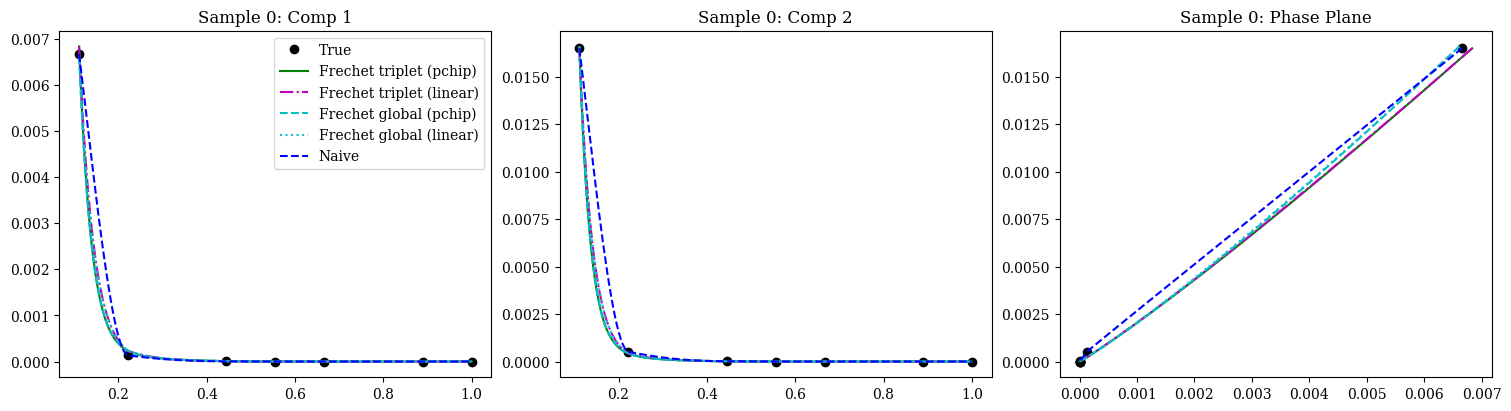

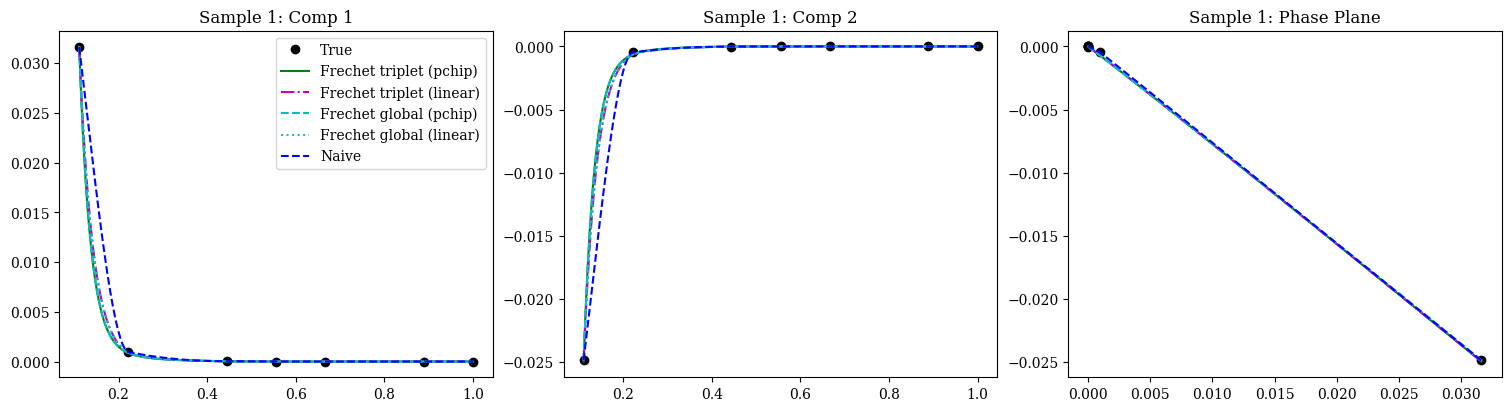

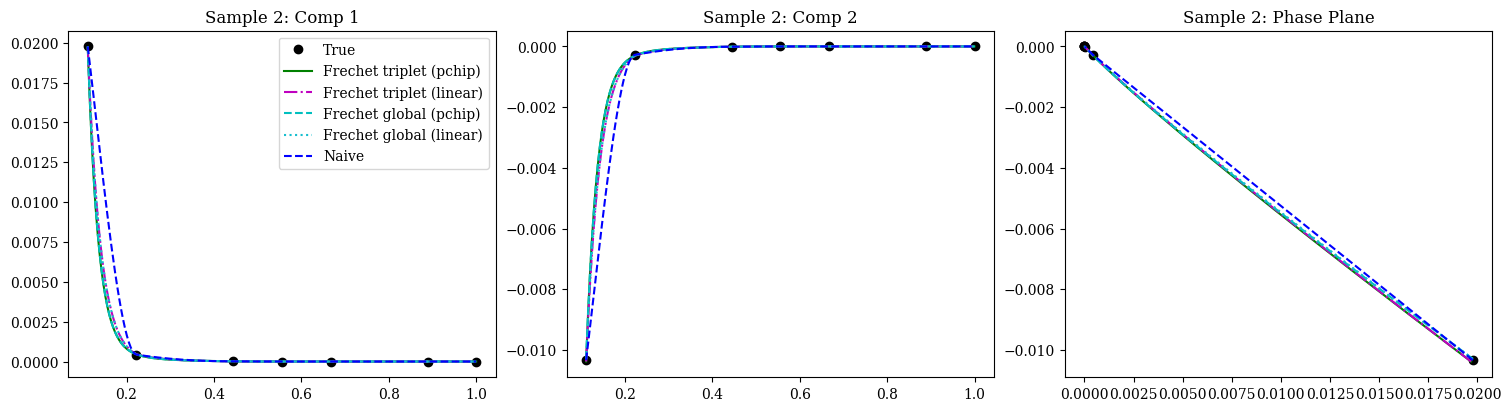

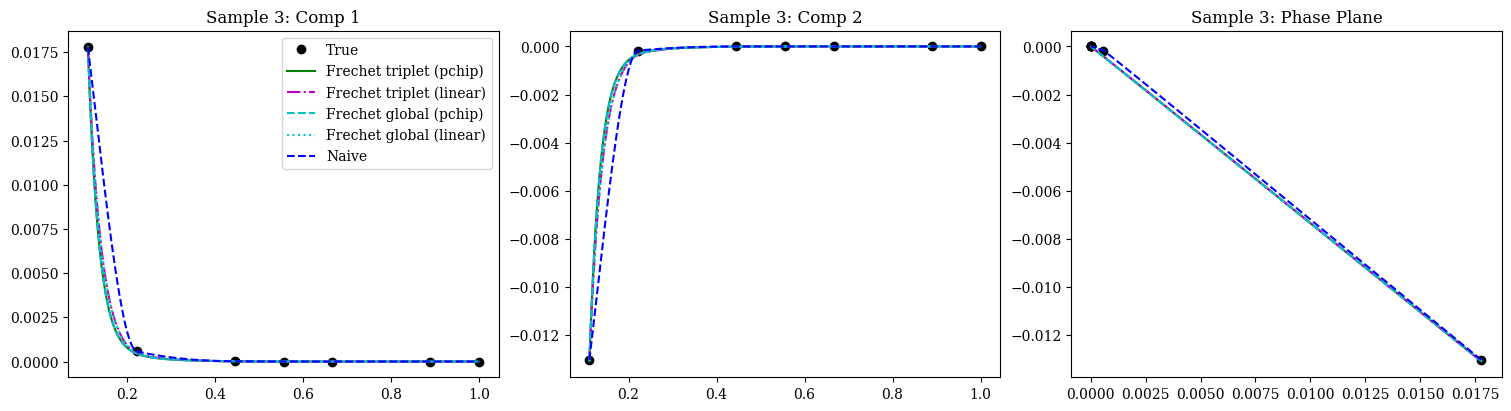

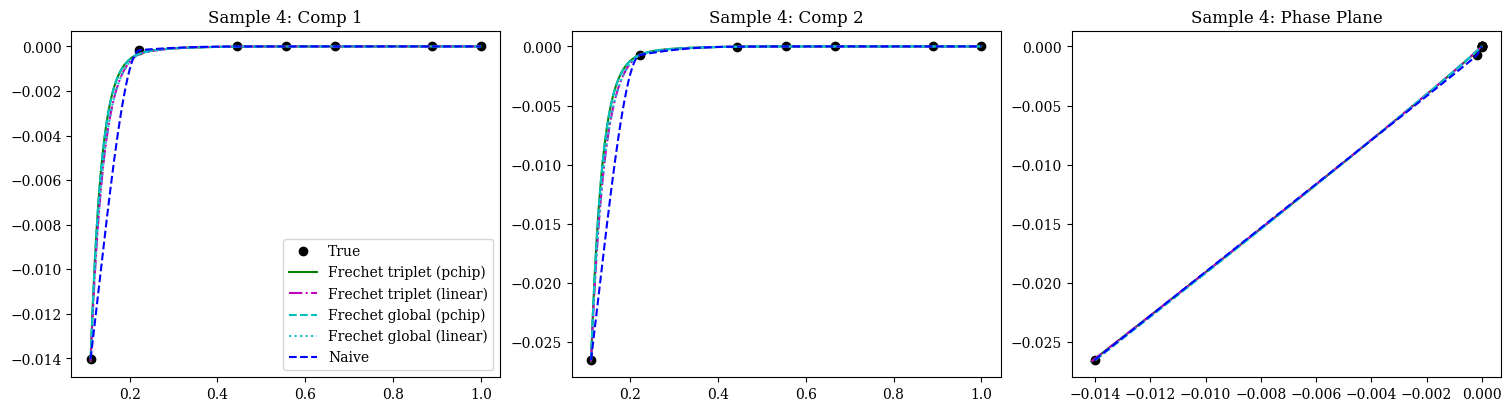

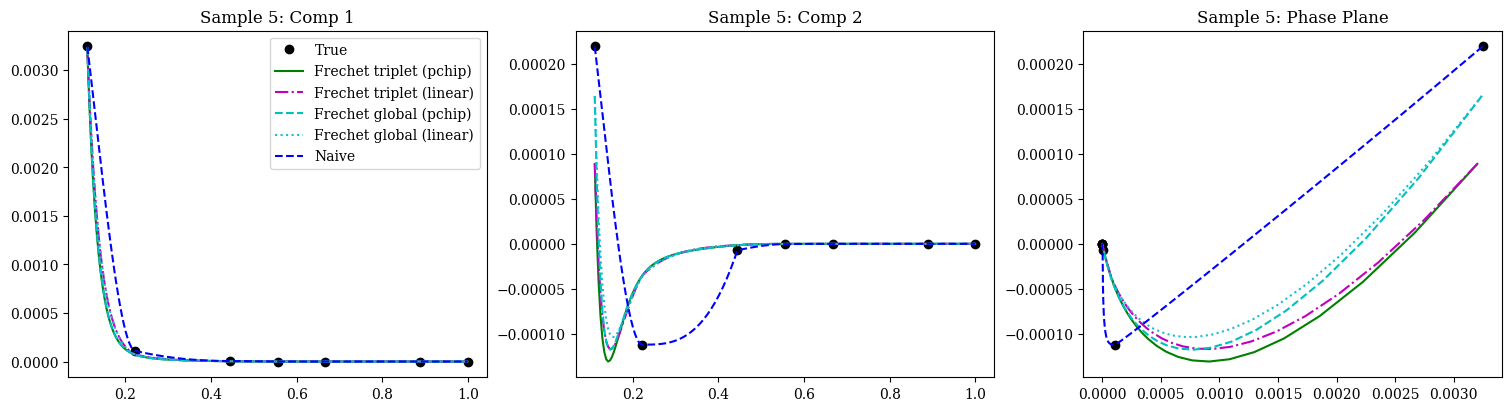

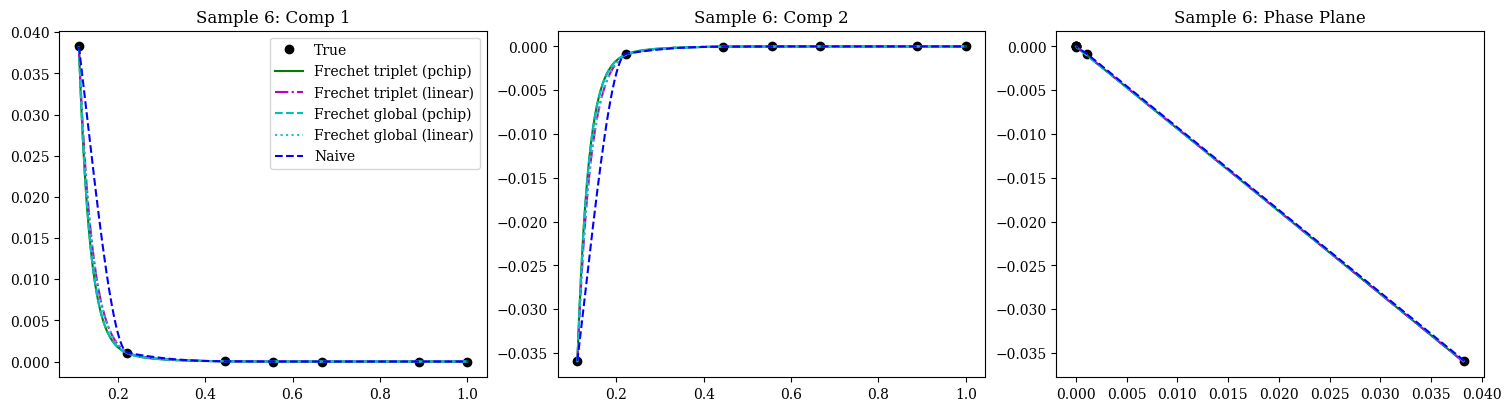

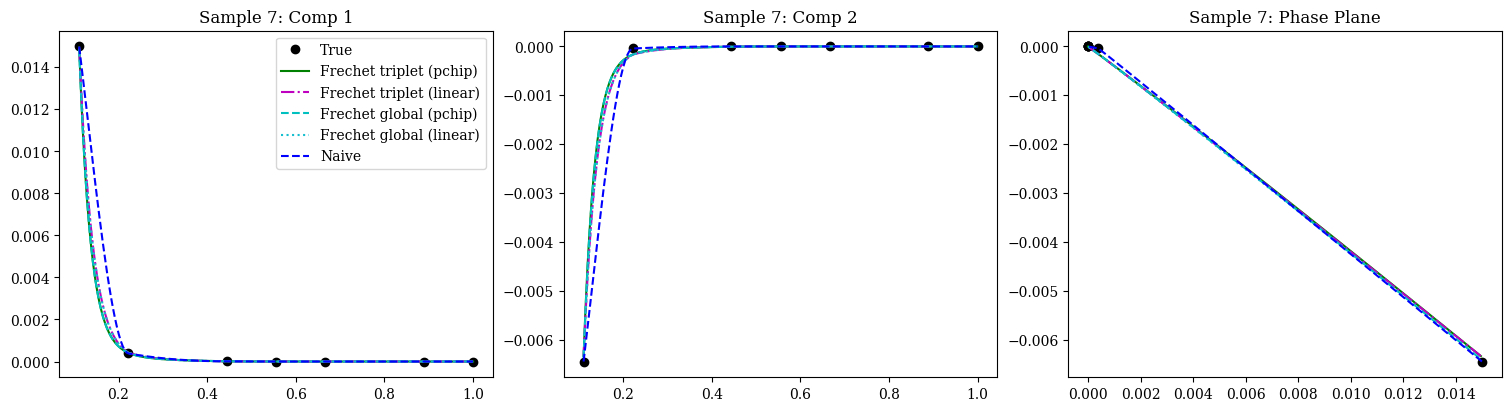

In [12]:

# --- Step 4: Build Dense Latent Trajectories ---
interpolation = build_dense_latent_trajectories(
    tc_result,
    times_train=times_arr,
    tc_embeddings_time=tc_embeddings_time,
    n_dense=pseudo_config.n_dense,
    frechet_mode=pseudo_config.frechet_mode,
)
interpolation_frechet_global = build_dense_latent_trajectories(
    tc_result,
    times_train=times_arr,
    tc_embeddings_time=tc_embeddings_time,
    n_dense=pseudo_config.n_dense,
    frechet_mode='global',
)

# Visualize the latent trajectories for a few samples
sample_indices_to_plot = list(range(pseudo_config.n_samples_vis))
plot_latent_trajectories_comparison(
    times_train=times_arr,
    tc_embeddings_time=tc_embeddings_time,
    interpolation_triplet=interpolation,
    interpolation_global=interpolation_frechet_global,
    sample_indices=sample_indices_to_plot,
)


Elbow-selected epsilons (with min-SGE reference):


,time,epsilon_elbow,semigroup_error_elbow,epsilon_min,semigroup_error_min,kde_bandwidth
0,0.111111,50.223723,0.062255,463.648888,0.011154,NaN
1,0.222222,37.872234,0.065423,385.096843,0.013060,NaN
2,0.444444,34.696004,0.067333,320.302099,0.015158,NaN
3,0.555556,31.660187,0.072913,292.276427,0.016070,NaN
4,0.666667,24.443559,0.069525,185.997601,0.022779,NaN
5,0.888889,16.151555,0.068504,83.499219,0.038178,NaN
6,1.000000,4.926470,0.066298,6.583274,0.060709,NaN


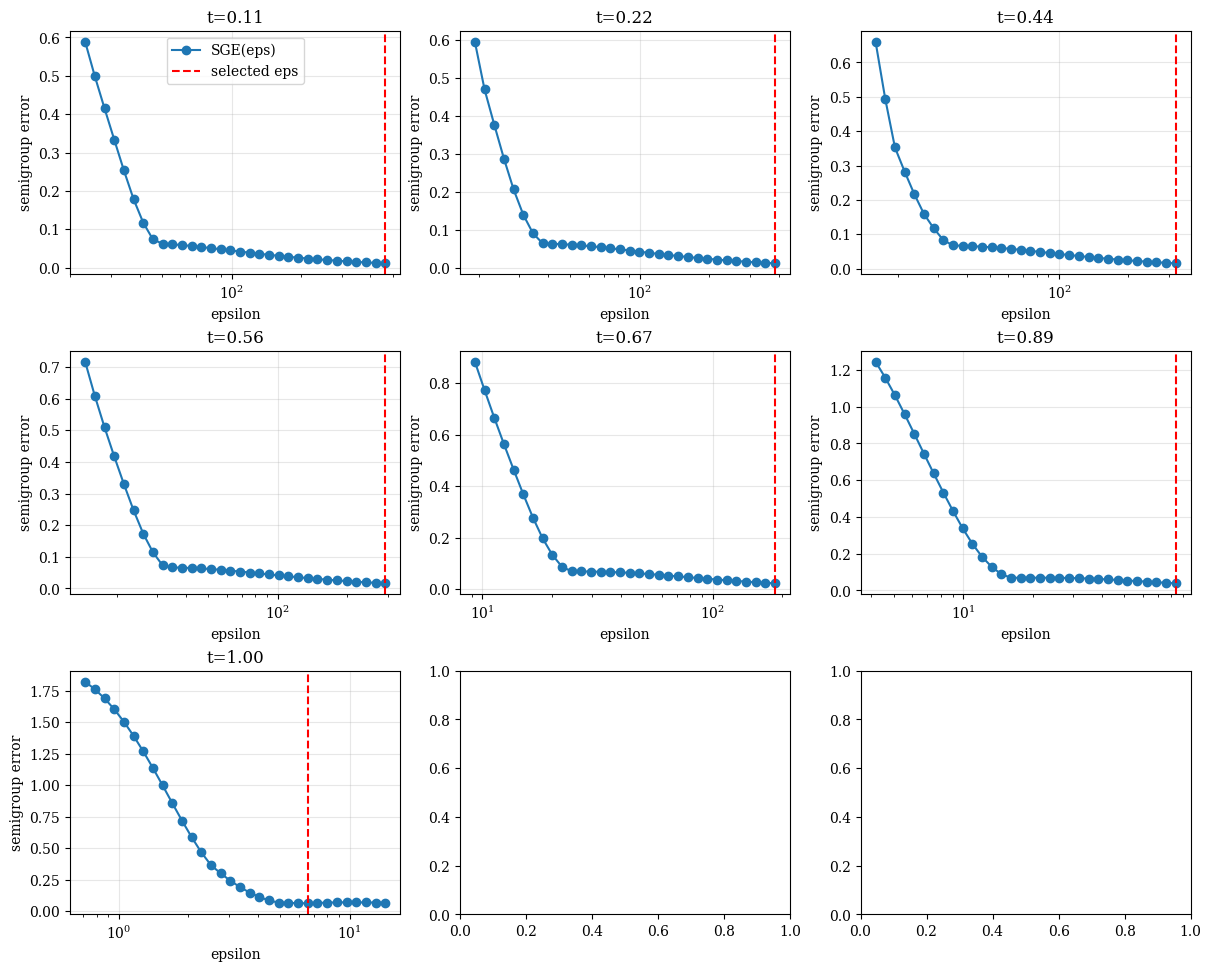

In [16]:
# --- Semigroup bandwidth diagnostics ---
from IPython.display import display

if semigroup_df is None or len(getattr(semigroup_df, "index", [])) == 0:
    print("Semigroup diagnostics unavailable.")
else:
    semigroup_best = (
        semigroup_df.sort_values("semigroup_error")
        .groupby("time_index")
        .first()
        .reset_index(drop=True)
    )
    semigroup_best = semigroup_best[
        ["time", "epsilon", "semigroup_error", "kde_bandwidth"]
    ]

    # Elbow summary (if available)
    if "epsilon_elbow" in semigroup_df.columns:
        elbow_rows = []
        for idx in sorted(semigroup_df["time_index"].unique()):
            subset = semigroup_df[semigroup_df["time_index"] == idx]
            eps_elb = float(subset["epsilon_elbow"].iloc[0])
            row = subset.loc[(subset["epsilon"].sub(eps_elb)).abs().idxmin()]
            elbow_rows.append(
                {
                    "time": float(row["time"]),
                    "epsilon_elbow": eps_elb,
                    "semigroup_error_elbow": float(row["semigroup_error"]),
                }
            )
        elbow_df = pd.DataFrame(elbow_rows)
        summary = elbow_df.merge(
            semigroup_best.rename(
                columns={
                    "epsilon": "epsilon_min",
                    "semigroup_error": "semigroup_error_min",
                }
            ),
            on="time",
            how="left",
        )
        print("Elbow-selected epsilons (with min-SGE reference):")
        display(summary)
    else:
        print("Semigroup-selected epsilons (min SGE):")
        display(semigroup_best)

    unique_times = semigroup_df["time_index"].unique()
    n_rows = int(np.ceil(len(unique_times) / 3)) if len(unique_times) else 1
    n_cols = min(3, max(1, len(unique_times)))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3.2 * n_rows),
        squeeze=False,
        constrained_layout=True,
    )

    for ax, idx in zip(axes.flat, unique_times):
        subset = semigroup_df[semigroup_df["time_index"] == idx].sort_values(
            "epsilon"
        )
        ax.plot(subset["epsilon"], subset["semigroup_error"], "o-", label="SGE(eps)")
        best_row = subset.loc[subset["semigroup_error"].idxmin()]
        ax.axvline(
            best_row["epsilon"],
            color="r",
            linestyle="--",
            label="selected eps",
        )
        ax.set_xscale("log")
        ax.set_title(f"t={subset['time'].iloc[0]:.2f}")
        ax.set_xlabel("epsilon")
        ax.set_ylabel("semigroup error")
        ax.grid(alpha=0.3)
    if axes.size:
        axes.flat[0].legend()
    plt.show()




In [ ]:
# Visualise one sample across times
from turtle import mode


sample_idx = 0
ncols = len(times_arr)
if ncols == 0:
    raise RuntimeError("No times found to plot. Check the npz keys printed above.")

fig, axes = plt.subplots(1, max(1, ncols), figsize=(4 * max(1, ncols), 4))
if ncols == 1:
    axes = [axes]

for ax, (i,t) in zip(axes, enumerate(times_arr)):
    field = raw_marginals[t][sample_idx].reshape(resolution, resolution)

    im = ax.imshow(field, cmap="viridis")
    ax.set_title(f"t={t}")
    ax.axis("off")

fig.colorbar(im, ax=axes[:ncols], shrink=0.8)
plt.show()

# plot held-out samples
if held_out_indices.size > 0:
    fig, axes = plt.subplots(1, max(1, ncols), figsize=(4 * max(1, ncols), 4))
    if ncols == 1:
        axes = [axes]

    for ax, (i,t) in zip(axes, enumerate(held_out_times)):
        if t in held_out_marginals:
            field = raw_marginals[t][sample_idx].reshape(resolution, resolution)
            im = ax.imshow(field, cmap="viridis")
            ax.set_title(f"Held-out t={t}")
            ax.axis("off")
        else:
            ax.axis("off")

    fig.colorbar(im, ax=axes[:ncols], shrink=0.8)
    plt.show()



In [ ]:
# --- Step 5: Fit Lifting Models on augmented data ---
lifting_config = LiftingConfig(
    holdout_time=times_arr[1],  # hold out a true observed time for diagnostics
)

models, lifting_metadata = fit_lifting_models(
    tc_embeddings_time,
    all_frames,
    times_arr,
    lifting_config,
    trajectory=tc_result,
)

# --- Basepoint selection experiment: global vs. Frechet (global/triplet) ---
basepoint_specs = [
    ("global_basepoint", interpolation, "global"),
    ("frechet_global_mean", interpolation_frechet_global, "frechet"),
    ("frechet_triplet", interpolation, "frechet"),
]
basepoint_eval = compare_basepoint_interpolations(
    tc_embeddings_time=tc_embeddings_time,
    all_frames=all_frames,
    times_arr=times_arr,
    basepoint_specs=basepoint_specs,
    models=models,
    lifting_metadata=lifting_metadata,
    config=lifting_config,
    components=components,
    mean_vec=mean_vec,
    explained_variance=explained_variance,
    is_whitened=is_whitened,
    whitening_epsilon=whitening_epsilon,
    resolution=resolution,
)

# --- Step 6: Lift held-out times and compare against ground truth ---
if held_out_times:
    eval_pairs: list[tuple[float, np.ndarray]] = []
    for t in held_out_times:
        matched: Optional[tuple[float, np.ndarray]] = None
        for t_key, frame in held_out_marginals.items():
            if abs(float(t_key) - float(t)) <= lifting_config.time_match_tol:
                matched = (float(t_key), frame)
                break
        if matched is None:
            print(f"No PCA marginal found for held-out time {t:.3f}; skipping.")
            continue
        eval_pairs.append(matched)

    if eval_pairs:
        eval_times = np.array([t for t, _ in eval_pairs], dtype=np.float64)
        eval_times, phi_eval = sample_latent_at_times(
            interpolation,
            eval_times,
            method=pseudo_config.interp_method,
        )
        pseudo_micro_eval = lift_pseudo_latents(
            phi_eval,
            eval_times,
            models,
            tc_embeddings_time,
            all_frames,
            times_arr,
            config=lifting_config,
            lifting_metadata=lifting_metadata,
        )
        sample_indices = tuple(idx for idx in lifting_config.plot_samples if idx < all_frames.shape[1])
        if not sample_indices:
            sample_indices = (0,)

        stacked_truth = []
        stacked_g = []
        stacked_preds: Dict[str, List[np.ndarray]] = {name: [] for name in pseudo_micro_eval}

        for i, (t_eval, X_true_pca) in enumerate(eval_pairs):
            print(f"--- Hold-out t={t_eval:.3f} ---")
            X_true_flat = pca_decode(
                X_true_pca,
                components,
                mean_vec,
                explained_variance,
                is_whitened,
                whitening_epsilon,
            )
            imgs_true = to_images(X_true_flat, resolution)

            preds_flat = {
                name: pca_decode(
                    pseudo_micro_eval[name][i],
                    components,
                    mean_vec,
                    explained_variance,
                    is_whitened,
                    whitening_epsilon,
                )
                for name in pseudo_micro_eval
            }
            imgs_preds = {name: to_images(arr, resolution) for name, arr in preds_flat.items()}

            lift_metrics = compute_lift_metrics(
                X_true_flat,
                None,
                None,
                preds_flat["convex"],
                None,
                preds_flat.get("tc_gh"),
            )
            print_metric_table(lift_metrics)
            plot_field_comparisons(
                imgs_true,
                imgs_preds.get("tc_gh", imgs_preds["convex"]),
                None,
                imgs_preds["convex"],
                sample_indices=sample_indices,
                imgs_krr=None,
                vmax_mode=lifting_config.vmax_mode,
            )
            plot_error_statistics(lift_metrics, phi_eval[i])

            stacked_truth.append(X_true_flat)
            stacked_g.append(phi_eval[i])
            for name, arr in preds_flat.items():
                stacked_preds[name].append(arr)

        if stacked_truth:
            X_true_all = np.vstack(stacked_truth)
            agg_preds = {name: np.vstack(arrs) for name, arrs in stacked_preds.items() if arrs}
            agg_metrics = compute_lift_metrics(
                X_true_all,
                None,
                None,
                agg_preds["convex"],
                None,
                agg_preds.get("tc_gh"),
            )
            print("Aggregate hold-out lift metrics across times:")
            print_metric_table(agg_metrics)
            plot_error_statistics(agg_metrics, np.vstack(stacked_g))
    else:
        print("Held-out times provided but no matching PCA marginals; skipping lift comparison.")
else:
    print("No held-out times provided; skipping lift comparison.")

# --- Step 7: Visualize fractional-operator PCA interpolants (per interval) ---
def visualize_fractional_pca_intervals(
    *,
    all_frames: np.ndarray,
    times_arr: np.ndarray,
    frames_aug: np.ndarray,
    pseudo_meta: Dict[str, Any],
    components,
    mean_vec,
    explained_variance,
    is_whitened: bool,
    whitening_epsilon: float,
    resolution: int,
    sample_indices: Tuple[int, ...],
) -> None:
    """Decode and plot pseudo PCA states between successive times."""
    pseudo_entries = [e for e in pseudo_meta['entries'] if e['kind'] == 'pseudo']
    if not pseudo_entries:
        print("No pseudo entries to visualise.")
        return

    pseudo_by_interval: Dict[int, list[dict[str, Any]]] = {}
    for entry in pseudo_entries:
        pseudo_by_interval.setdefault(entry['interval_index'], []).append(entry)
    for entries in pseudo_by_interval.values():
        entries.sort(key=lambda e: e['time'])

    for interval_idx, entries in pseudo_by_interval.items():
        t_start = times_arr[interval_idx]
        t_end = times_arr[interval_idx + 1]
        frame_start = all_frames[interval_idx]
        frame_end = all_frames[interval_idx + 1]

        # Decode true endpoints
        imgs_true_times: Dict[float, np.ndarray] = {}
        X_start_flat = pca_decode(frame_start, components, mean_vec, explained_variance, is_whitened, whitening_epsilon)
        X_end_flat = pca_decode(frame_end, components, mean_vec, explained_variance, is_whitened, whitening_epsilon)
        imgs_true_times[float(t_start)] = to_images(X_start_flat, resolution)
        imgs_true_times[float(t_end)] = to_images(X_end_flat, resolution)

        # Decode pseudo frames
        imgs_pseudo_times: Dict[float, Dict[str, np.ndarray]] = {}
        for entry in entries:
            t_star = float(entry['time'])
            idx = entry['aug_index']
            X_pseudo_flat = pca_decode(
                frames_aug[idx],
                components,
                mean_vec,
                explained_variance,
                is_whitened,
                whitening_epsilon,
            )
            imgs_pseudo_times[t_star] = {'fused_step': to_images(X_pseudo_flat, resolution)}

        print(f"Interval [{t_start:.2f}, {t_end:.2f}] → {len(entries)} pseudo states at {sorted(imgs_pseudo_times.keys())}")
        plot_field_time_strips(
            imgs_true_times,
            imgs_pseudo_times,
            sample_indices=sample_indices,
            times_arr=times_arr,
        )


visualize_fractional_pca_intervals(
    all_frames=all_frames,
    times_arr=times_arr,
    frames_aug=frames_aug,
    pseudo_meta=pseudo_meta,
    components=components,
    mean_vec=mean_vec,
    explained_variance=explained_variance,
    is_whitened=is_whitened,
    whitening_epsilon=whitening_epsilon,
    resolution=resolution,
    sample_indices=tuple(range(min(pseudo_config.n_samples_fields, all_frames.shape[1]))),
)



findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


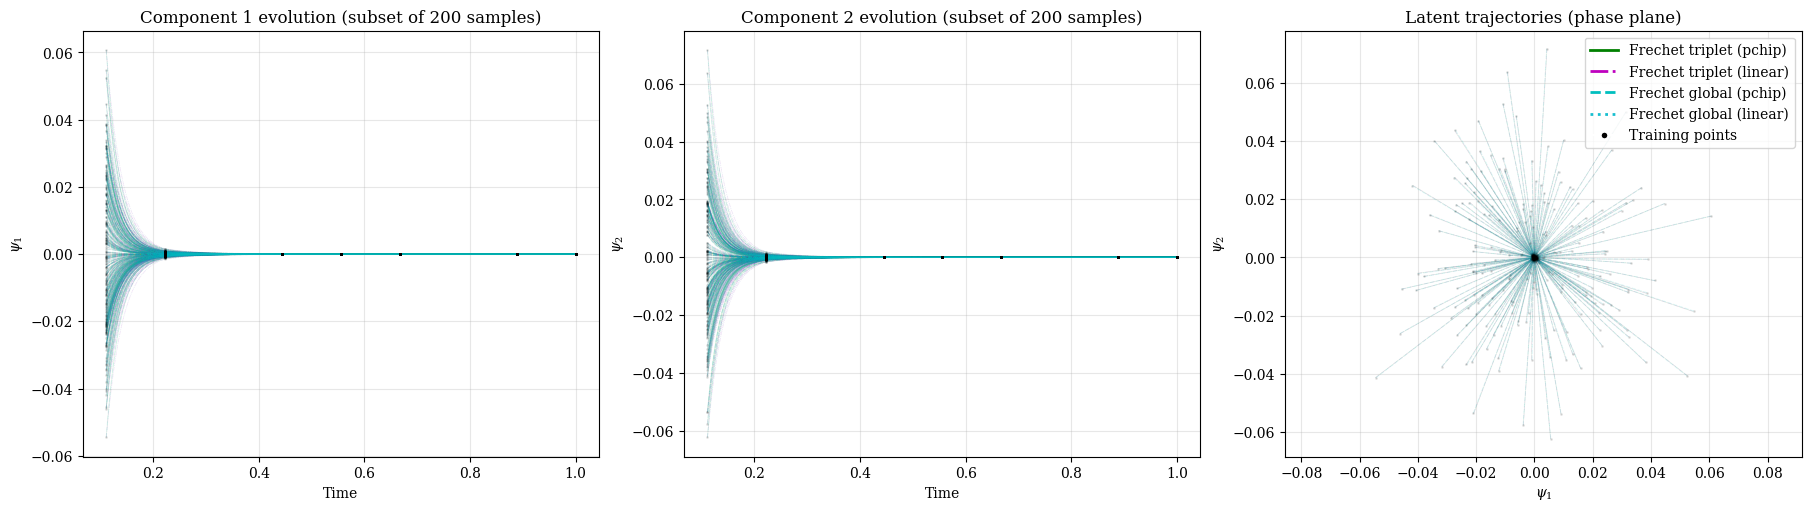

In [13]:
# --- Interpolation coverage across samples (Frechet triplet vs global) ---
t_dense = interpolation.t_dense
phi_frechet_triplet = interpolation.phi_frechet_dense
phi_linear_triplet = getattr(interpolation, 'phi_linear_dense', None)
phi_frechet_global = interpolation_frechet_global.phi_frechet_dense
phi_linear_global = getattr(interpolation_frechet_global, 'phi_linear_dense', None)
times_train = times_arr
n_samples_total = phi_frechet_triplet.shape[1]
sample_mask = np.arange(min(n_samples_total, 200))
phi_frechet_triplet = phi_frechet_triplet[:, sample_mask]
phi_frechet_global = phi_frechet_global[:, sample_mask]
if phi_linear_triplet is not None:
    phi_linear_triplet = phi_linear_triplet[:, sample_mask]
if phi_linear_global is not None:
    phi_linear_global = phi_linear_global[:, sample_mask]
tc_embeddings_plot = tc_embeddings_time[:, sample_mask]
t_flat = np.repeat(times_train, len(sample_mask))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
alpha_val = 0.1
color_interp = "g"
color_linear = "m"
color_train = "k"

axes[0].plot(
    t_dense,
    phi_frechet_triplet[:, :, 0],
    color=color_interp,
    alpha=alpha_val,
    linewidth=0.5,
)
if phi_linear_triplet is not None:
    axes[0].plot(
        t_dense,
        phi_linear_triplet[:, :, 0],
        color=color_linear,
        alpha=alpha_val,
        linewidth=0.5,
        linestyle='-.',
    )
axes[0].plot(
    t_dense,
    phi_frechet_global[:, :, 0],
    color='c',
    alpha=alpha_val,
    linewidth=0.8,
    linestyle='--',
)
if phi_linear_global is not None:
    axes[0].plot(
        t_dense,
        phi_linear_global[:, :, 0],
        color='tab:cyan',
        alpha=alpha_val,
        linewidth=0.5,
        linestyle=':',
    )
axes[0].scatter(
    t_flat,
    tc_embeddings_plot[:, :, 0].flatten(),
    color=color_train,
    s=1,
    alpha=0.1,
    zorder=2,
)
axes[0].set_title(f"Component 1 evolution (subset of {len(sample_mask)} samples)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("$\\psi_1$")
axes[0].grid(alpha=0.3)

axes[1].plot(
    t_dense,
    phi_frechet_triplet[:, :, 1],
    color=color_interp,
    alpha=alpha_val,
    linewidth=0.5,
)
if phi_linear_triplet is not None:
    axes[1].plot(
        t_dense,
        phi_linear_triplet[:, :, 1],
        color=color_linear,
        alpha=alpha_val,
        linewidth=0.5,
        linestyle='-.',
    )
axes[1].plot(
    t_dense,
    phi_frechet_global[:, :, 1],
    color='c',
    alpha=alpha_val,
    linewidth=0.8,
    linestyle='--',
)
if phi_linear_global is not None:
    axes[1].plot(
        t_dense,
        phi_linear_global[:, :, 1],
        color='tab:cyan',
        alpha=alpha_val,
        linewidth=0.5,
        linestyle=':',
    )
axes[1].scatter(
    t_flat,
    tc_embeddings_plot[:, :, 1].flatten(),
    color=color_train,
    s=1,
    alpha=0.1,
    zorder=2,
)
axes[1].set_title(f"Component 2 evolution (subset of {len(sample_mask)} samples)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("$\\psi_2$")
axes[1].grid(alpha=0.3)

axes[2].plot(
    phi_frechet_triplet[:, :, 0],
    phi_frechet_triplet[:, :, 1],
    color=color_interp,
    alpha=alpha_val,
    linewidth=0.5,
)
if phi_linear_triplet is not None:
    axes[2].plot(
        phi_linear_triplet[:, :, 0],
        phi_linear_triplet[:, :, 1],
        color=color_linear,
        alpha=alpha_val,
        linewidth=0.5,
        linestyle='-.',
    )
axes[2].plot(
    phi_frechet_global[:, :, 0],
    phi_frechet_global[:, :, 1],
    color='c',
    alpha=alpha_val,
    linewidth=0.8,
    linestyle='--',
)
if phi_linear_global is not None:
    axes[2].plot(
        phi_linear_global[:, :, 0],
        phi_linear_global[:, :, 1],
        color='tab:cyan',
        alpha=alpha_val,
        linewidth=0.5,
        linestyle=':',
    )
axes[2].scatter(
    tc_embeddings_plot[:, :, 0].flatten(),
    tc_embeddings_plot[:, :, 1].flatten(),
    color=color_train,
    s=1,
    alpha=0.1,
    zorder=2,
)
axes[2].set_title("Latent trajectories (phase plane)")
axes[2].set_xlabel("$\\psi_1$")
axes[2].set_ylabel("$\\psi_2$")
axes[2].grid(alpha=0.3)
axes[2].axis("equal")

from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color=color_interp, lw=2),
]
if phi_linear_triplet is not None:
    custom_lines.append(Line2D([0], [0], color=color_linear, lw=2, linestyle='-.'))
custom_lines.append(Line2D([0], [0], color='c', lw=2, linestyle='--'))
if phi_linear_global is not None:
    custom_lines.append(Line2D([0], [0], color='tab:cyan', lw=2, linestyle=':'))
custom_lines.append(
    Line2D([0], [0], marker="o", color="w", markerfacecolor=color_train, markersize=5),
)
labels = ["Frechet triplet (pchip)"]
if phi_linear_triplet is not None:
    labels.append("Frechet triplet (linear)")
labels.append("Frechet global (pchip)")
if phi_linear_global is not None:
    labels.append("Frechet global (linear)")
labels.append("Training points")
axes[2].legend(custom_lines, labels, loc="best")

plt.show()




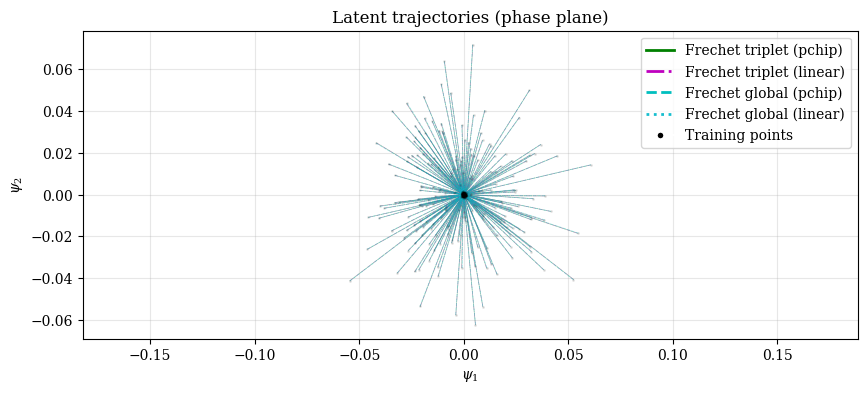

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    phi_frechet_triplet[:, :, 0],
    phi_frechet_triplet[:, :, 1],
    color=color_interp,
    alpha=0.3,
    linewidth=0.5,
)
if phi_linear_triplet is not None:
    ax.plot(
        phi_linear_triplet[:, :, 0],
        phi_linear_triplet[:, :, 1],
        color=color_linear,
        alpha=0.3,
        linewidth=0.5,
        linestyle='-.',
    )
ax.plot(
    phi_frechet_global[:, :, 0],
    phi_frechet_global[:, :, 1],
    color='c',
    alpha=0.3,
    linewidth=0.6,
    linestyle='--',
)
if phi_linear_global is not None:
    ax.plot(
        phi_linear_global[:, :, 0],
        phi_linear_global[:, :, 1],
        color='tab:cyan',
        alpha=0.3,
        linewidth=0.5,
        linestyle=':',
    )
ax.scatter(
    tc_embeddings_plot[:, :, 0].flatten(),
    tc_embeddings_plot[:, :, 1].flatten(),
    color=color_train,
    s=1,
    alpha=0.1,
    zorder=2,
)
ax.set_title("Latent trajectories (phase plane)")
ax.set_xlabel("$\\psi_1$")
ax.set_ylabel("$\\psi_2$")
ax.grid(alpha=0.3)
ax.axis("equal")

from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color=color_interp, lw=2),
]
if phi_linear_triplet is not None:
    custom_lines.append(Line2D([0], [0], color=color_linear, lw=2, linestyle='-.'))
custom_lines.append(Line2D([0], [0], color='c', lw=2, linestyle='--'))
if phi_linear_global is not None:
    custom_lines.append(Line2D([0], [0], color='tab:cyan', lw=2, linestyle=':'))
custom_lines.append(
    Line2D([0], [0], marker="o", color="w", markerfacecolor=color_train, markersize=5),
)
labels = ["Frechet triplet (pchip)"]
if phi_linear_triplet is not None:
    labels.append("Frechet triplet (linear)")
labels.append("Frechet global (pchip)")
if phi_linear_global is not None:
    labels.append("Frechet global (linear)")
labels.append("Training points")
ax.legend(custom_lines, labels, loc="best")
plt.show()




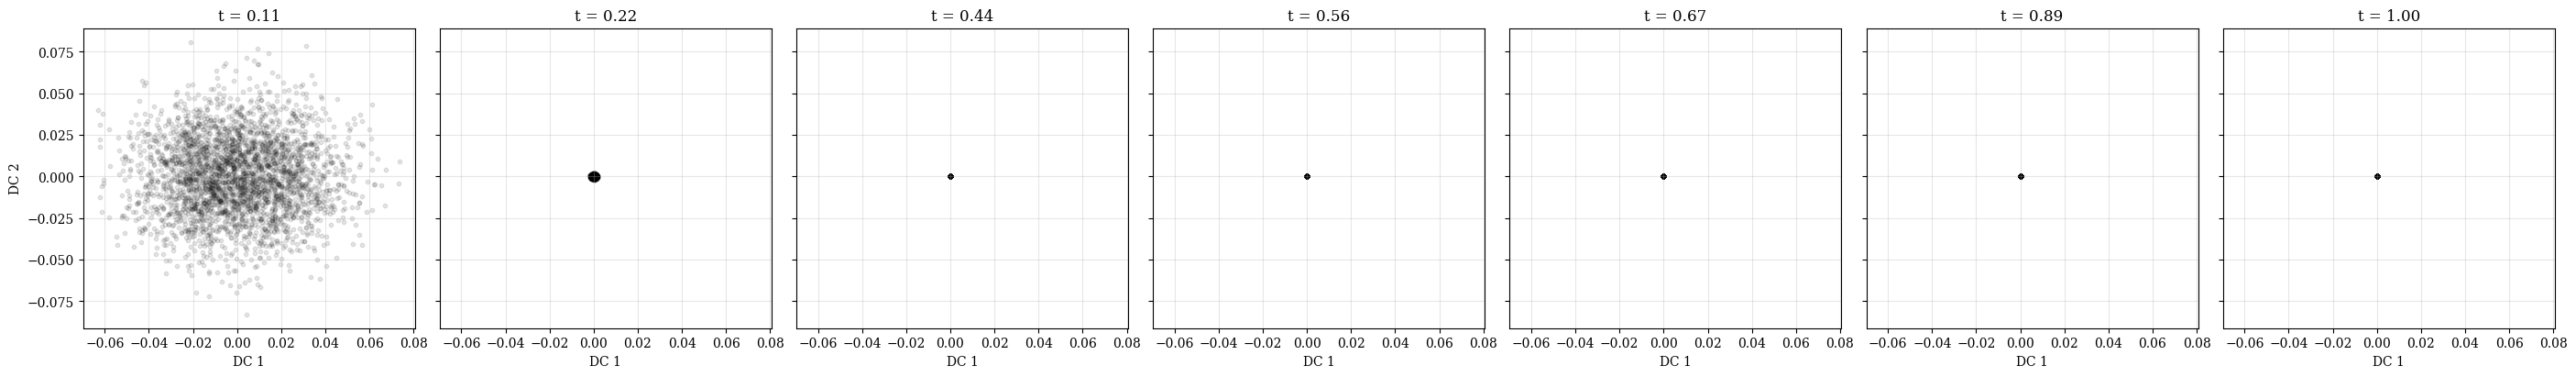

In [15]:
from matplotlib import colors as mcolors
from matplotlib.pylab import norm
# use index as coloring
n_times = tc_embeddings_time.shape[0]
n_samples = tc_embeddings_time.shape[1]

fig, axes = plt.subplots(1, n_times, figsize=(4 * n_times, 4), sharex=True, sharey=True, constrained_layout=True)
if n_times == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    coords = tc_embeddings_time[i]
    sc = ax.scatter(coords[:, 0], coords[:, 1], c='black', s=10, alpha=0.1)
    ax.set_title(f"t = {times_arr[i]:.2f}")
    ax.set_xlabel('DC 1')
    if i == 0:
        ax.set_ylabel('DC 2')
    ax.grid(alpha=0.3)
plt.show()

